## 1. Imports

In [1]:
from collections import deque

import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from skimage import io
import cv2

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.ndimage import label

import weak_annotator

## 2. Bounding Box

In [4]:
# 0. Initialize base path and pattern
base_path = r'C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fall\02516 - Intro 2 DL in CV\Projects\Project 3\PH2_Dataset_images'
pattern = os.path.join(base_path, 'IMD???', 'IMD???_lesion', 'IMD???_lesion.bmp')

resize_dim = None
# resize_dim = (576, 768)

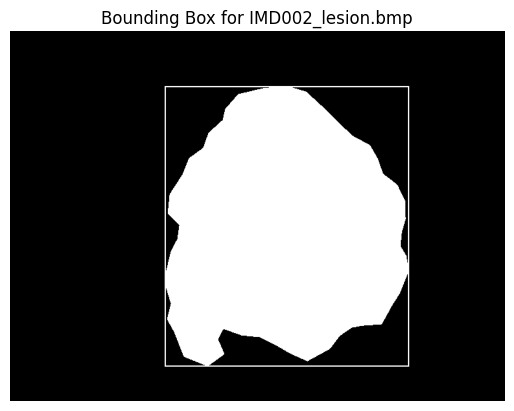

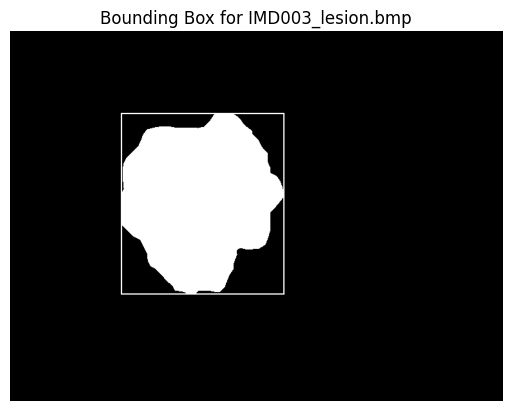

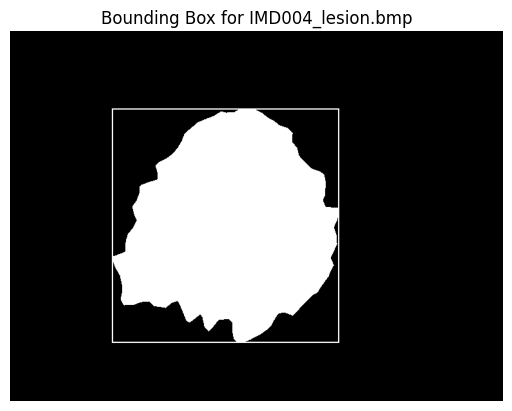

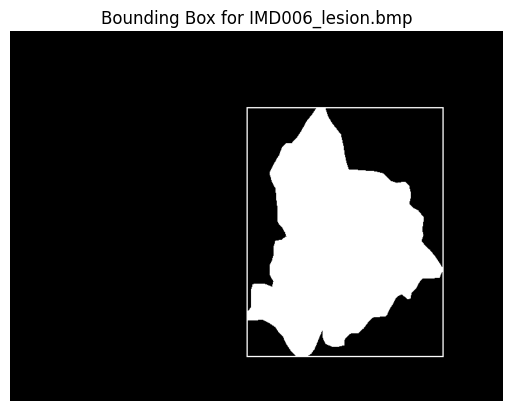

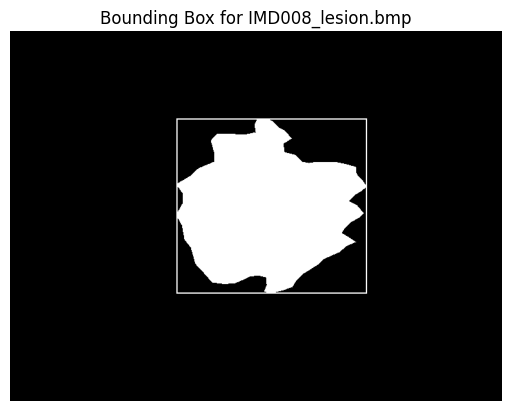

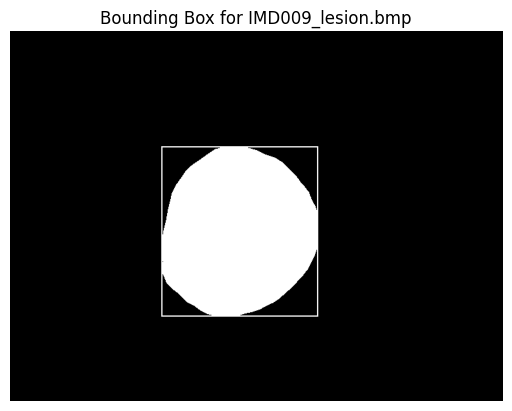

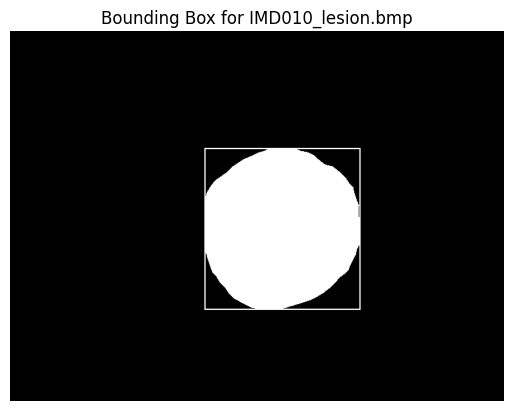

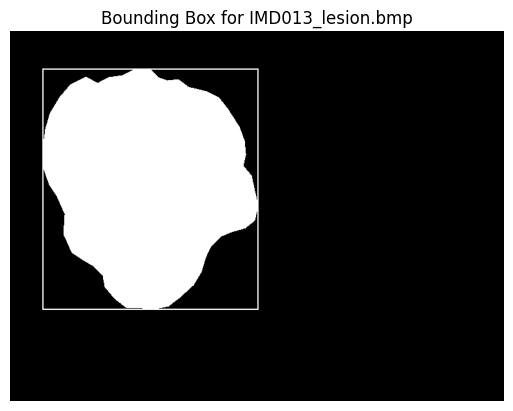

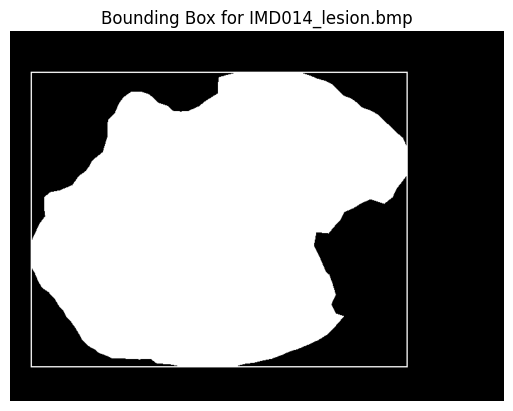

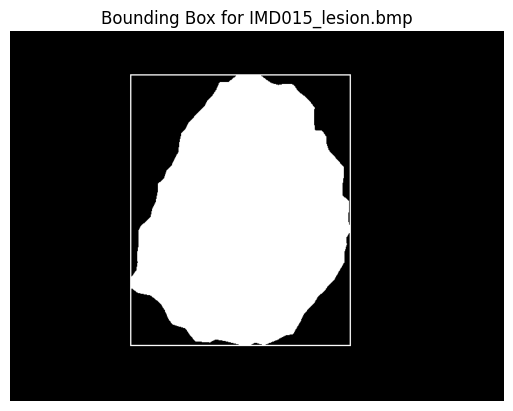

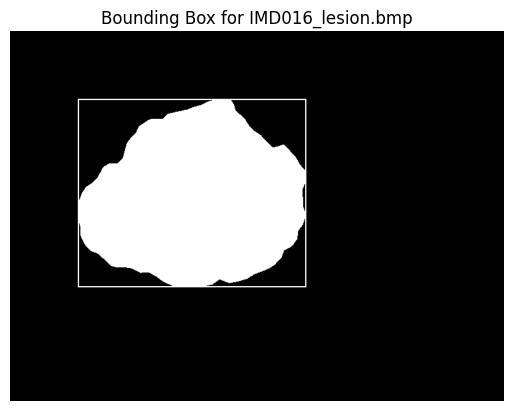

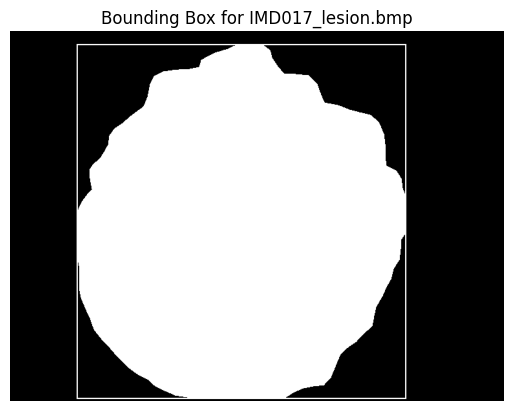

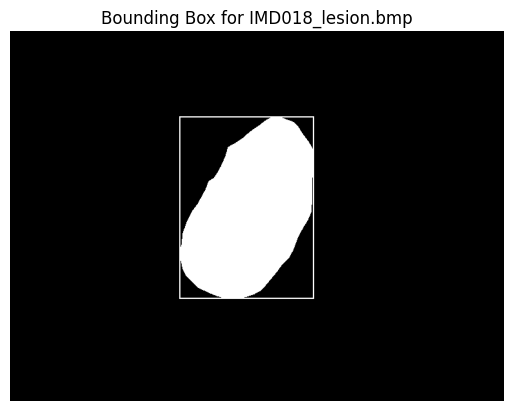

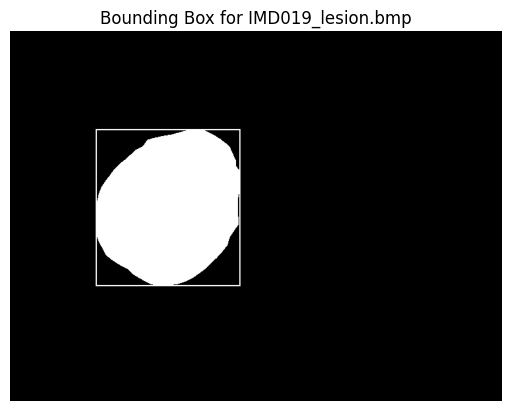

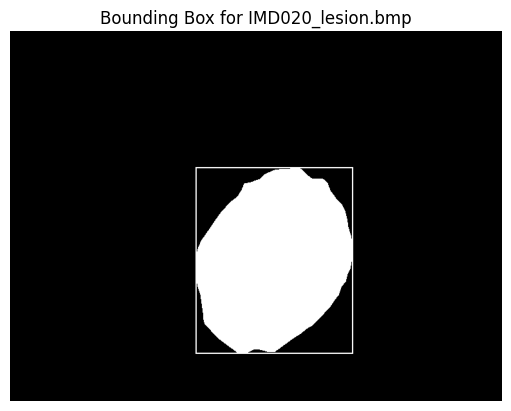

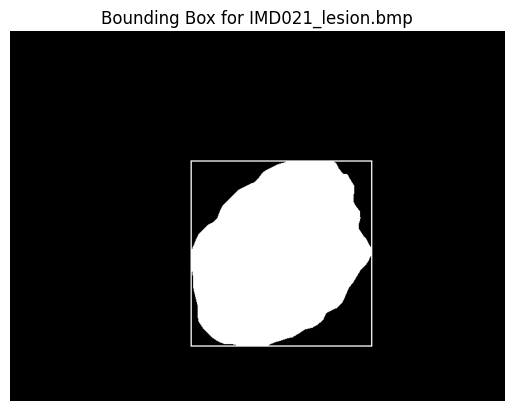

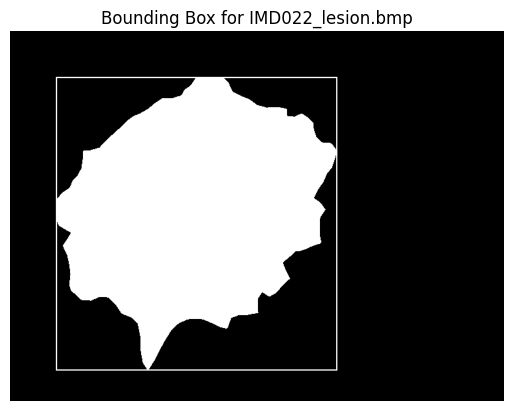

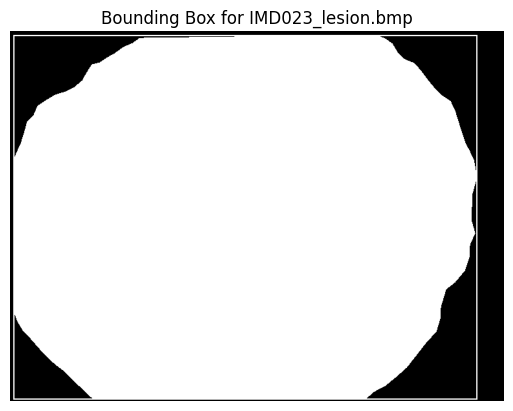

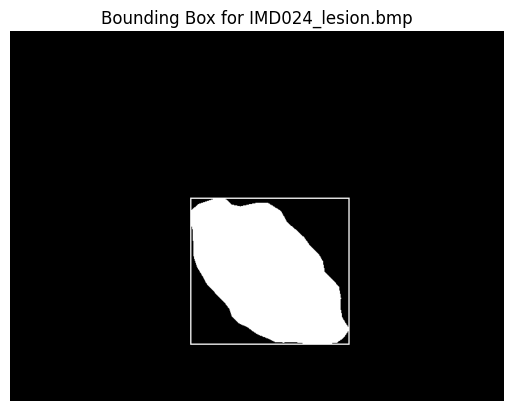

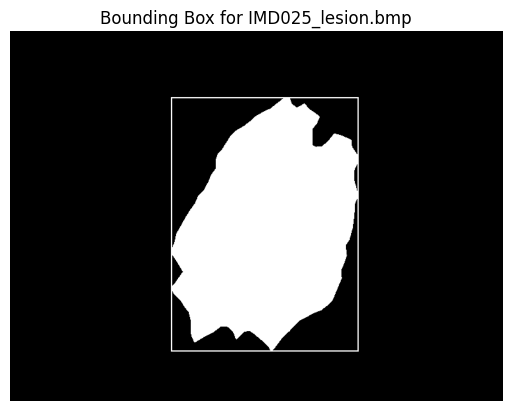

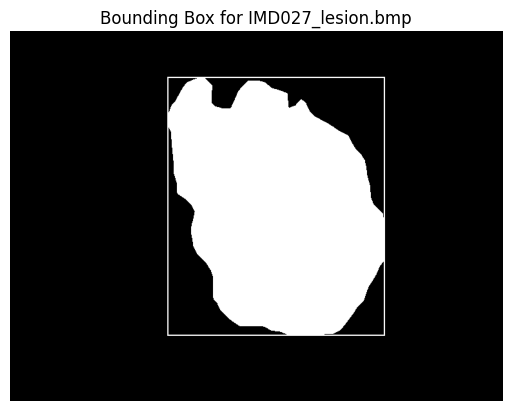

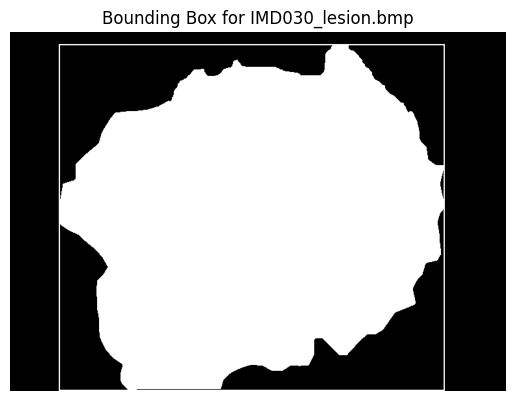

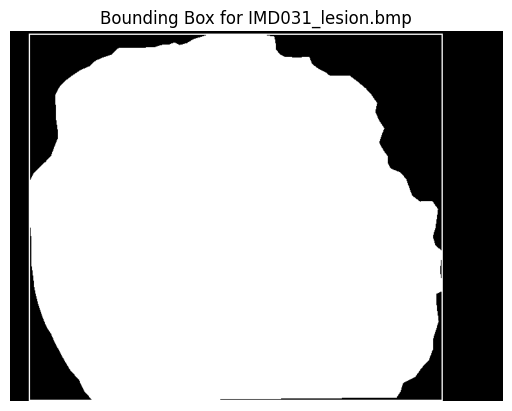

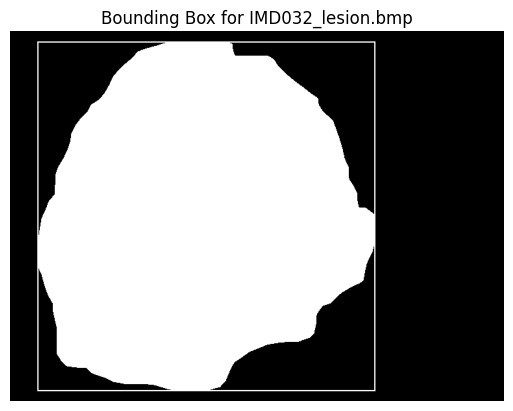

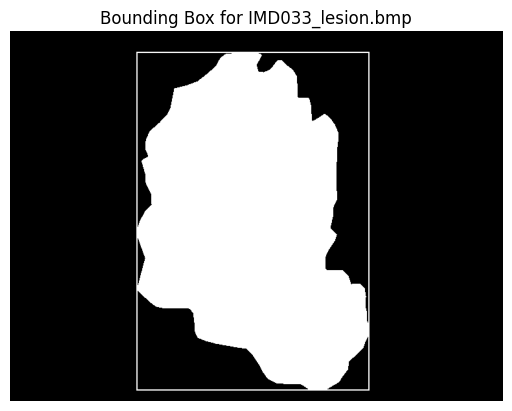

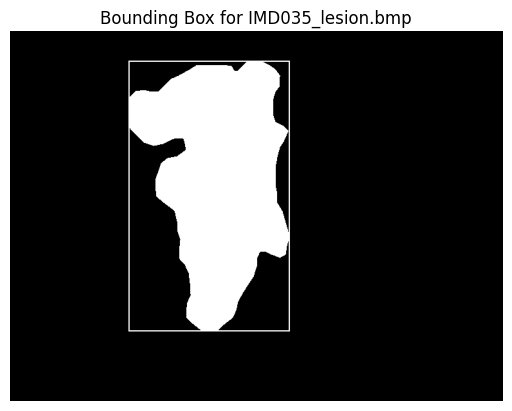

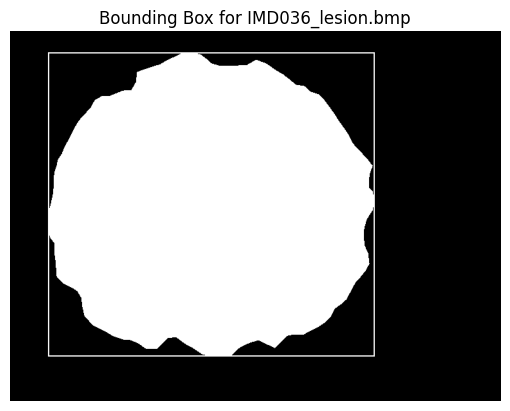

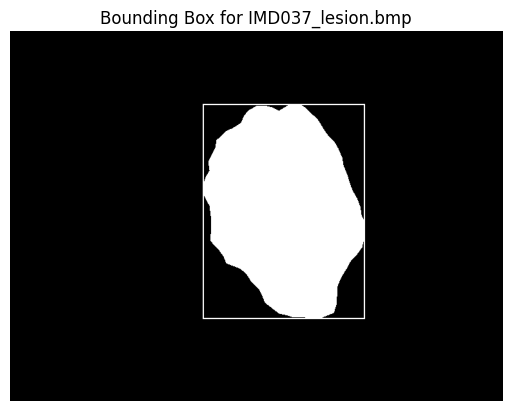

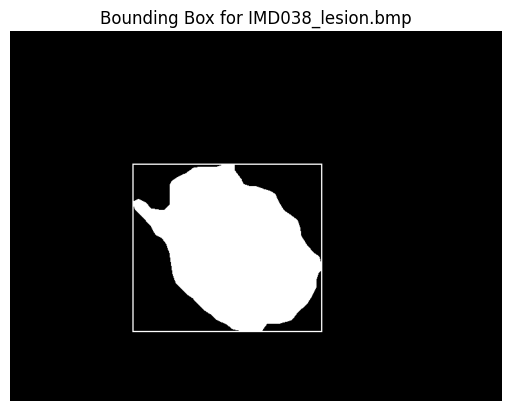

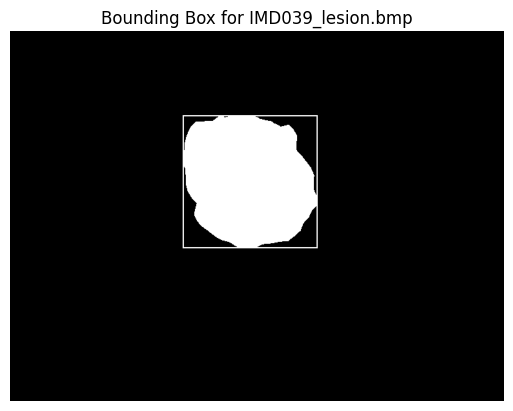

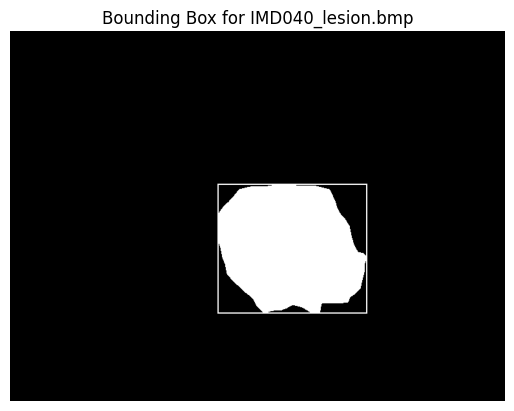

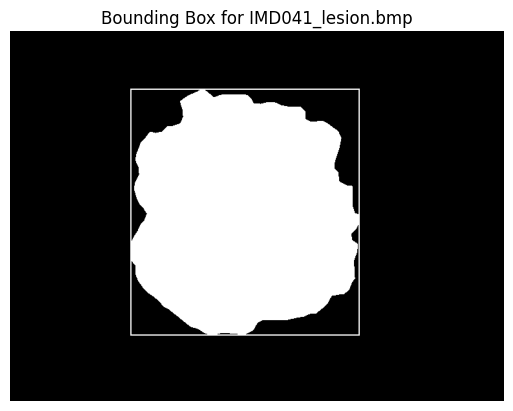

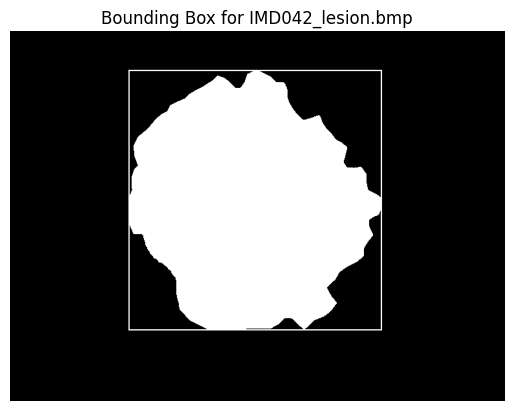

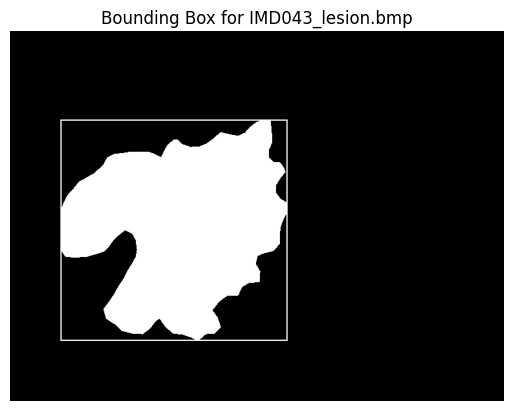

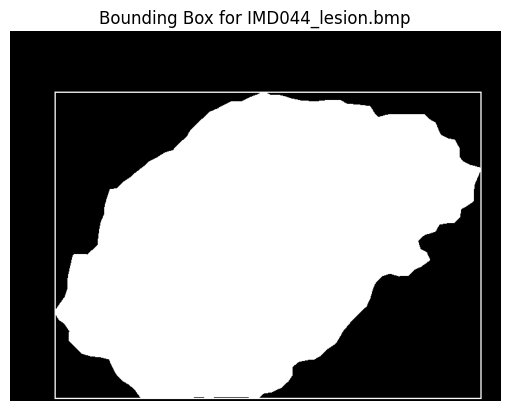

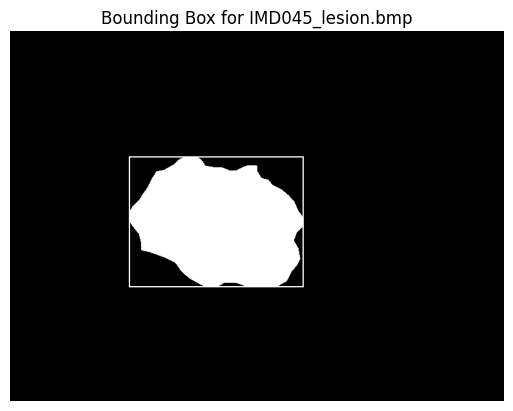

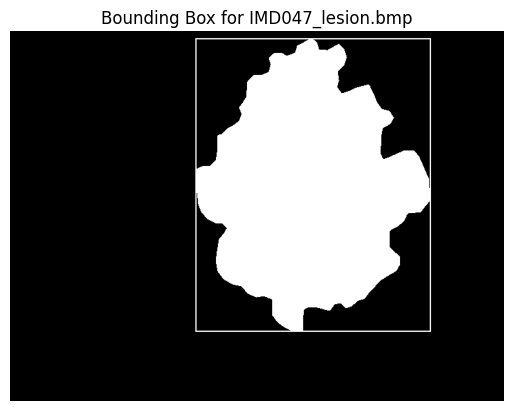

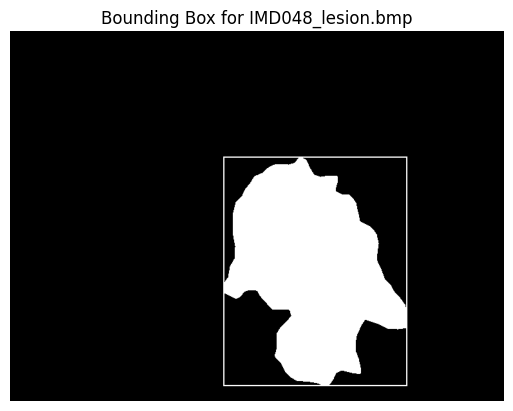

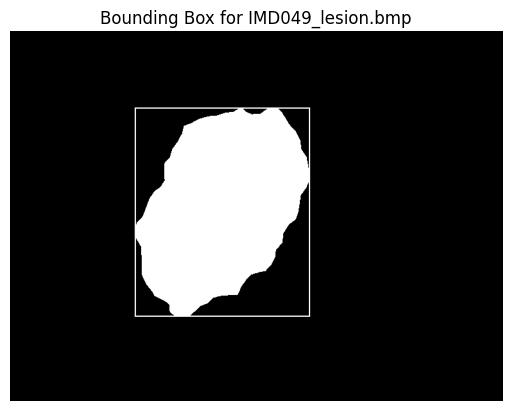

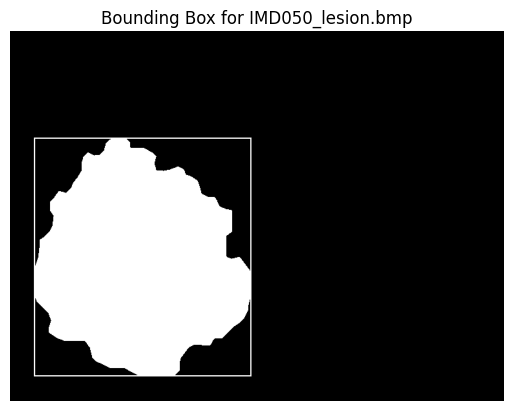

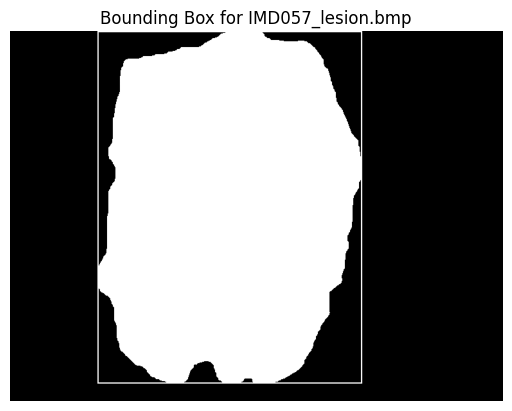

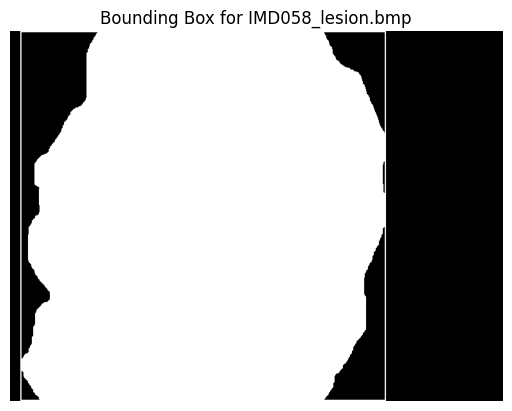

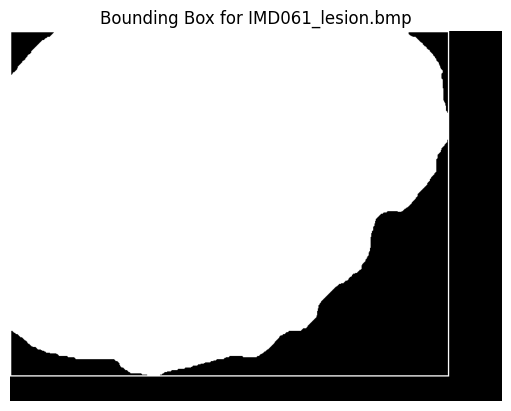

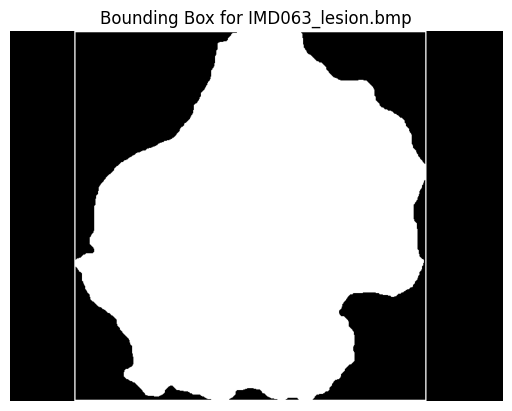

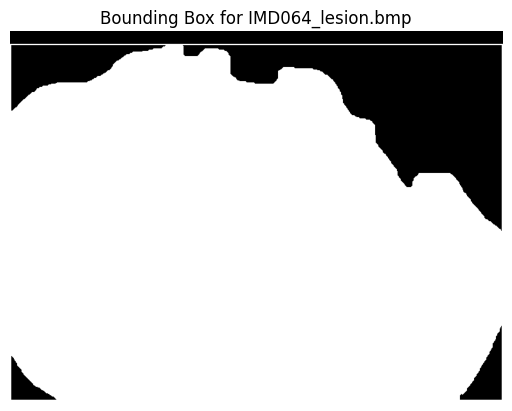

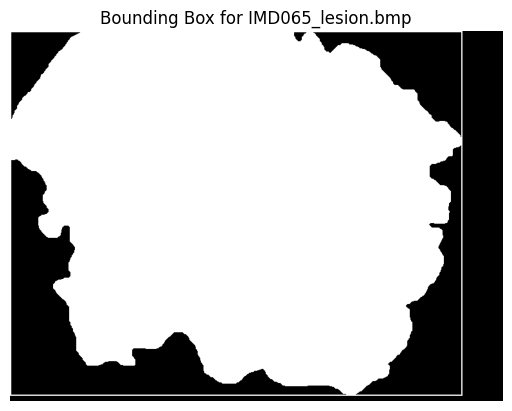

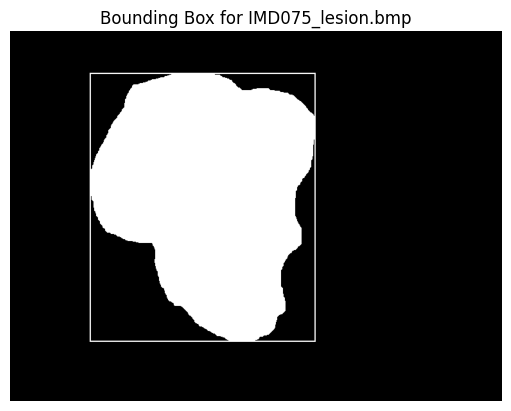

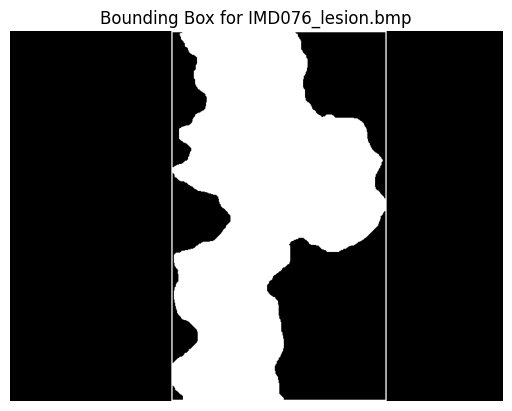

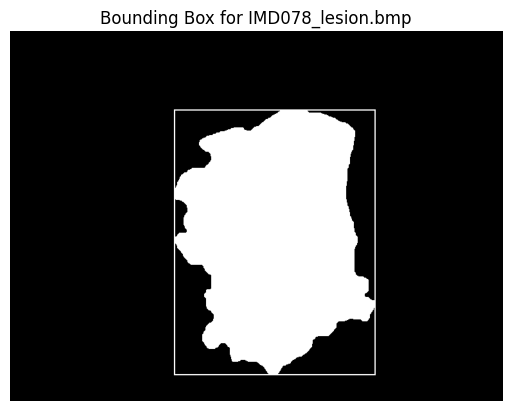

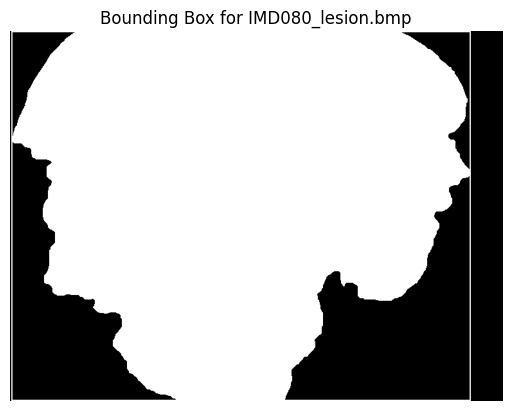

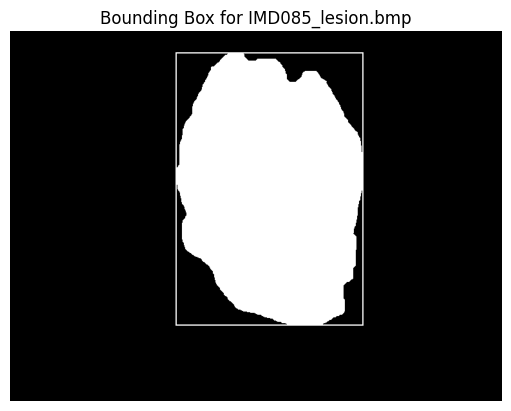

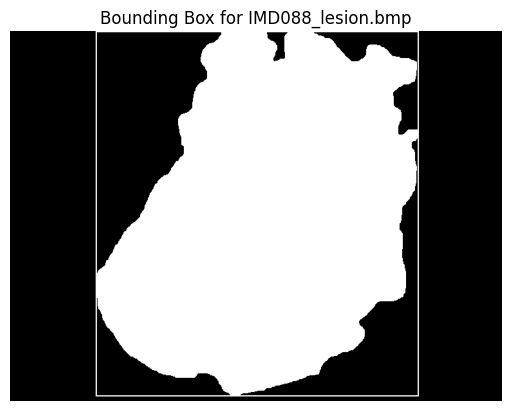

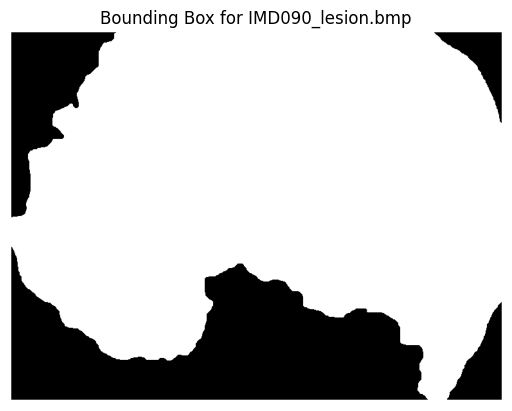

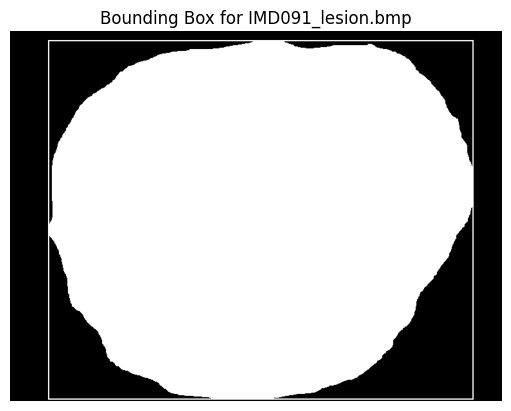

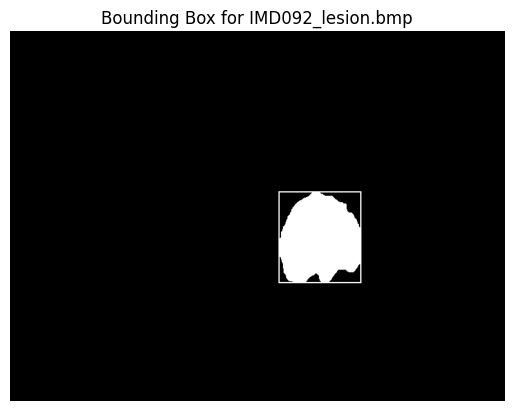

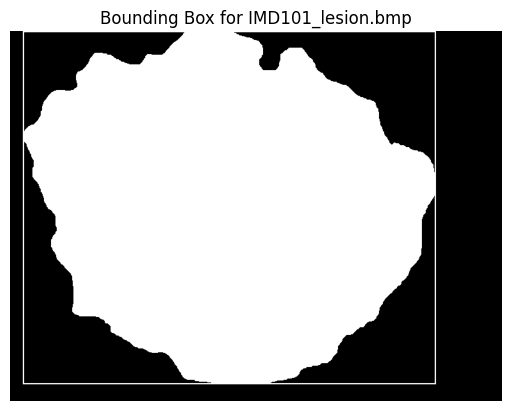

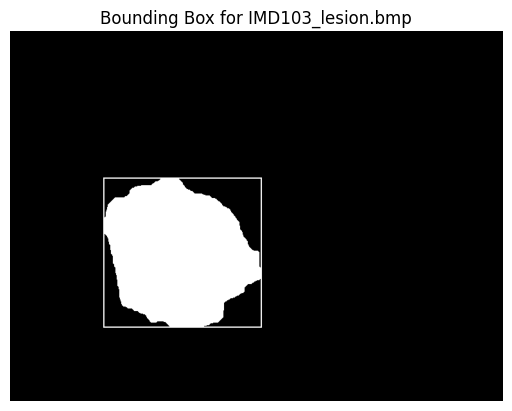

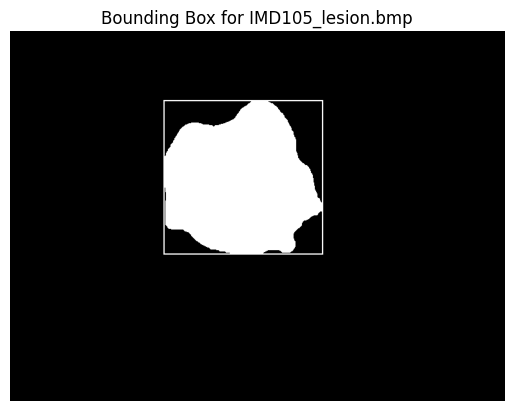

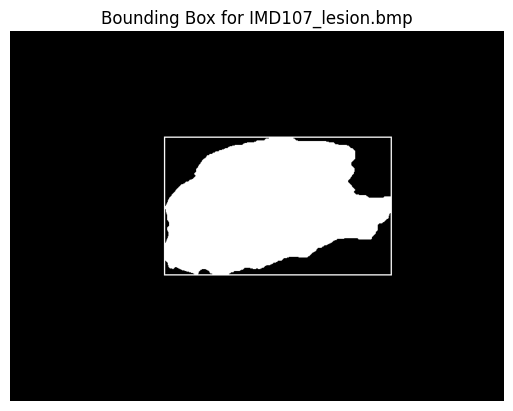

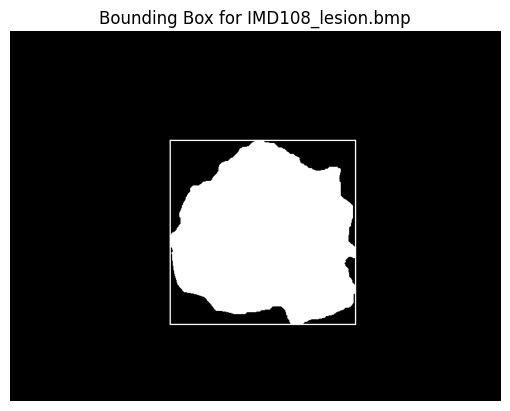

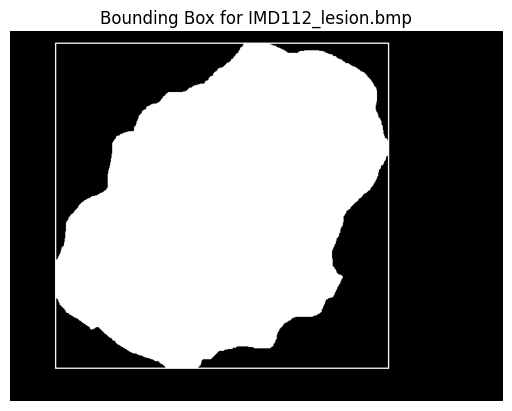

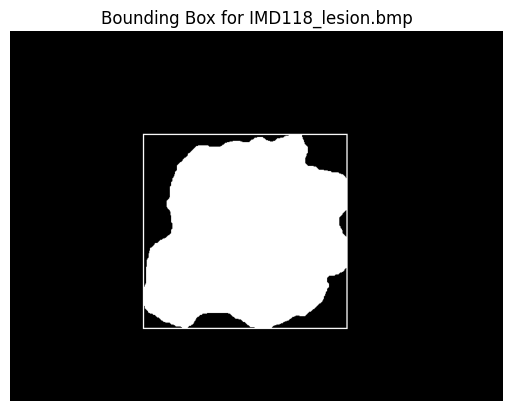

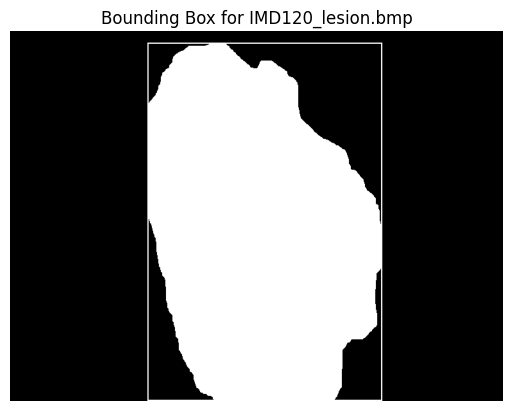

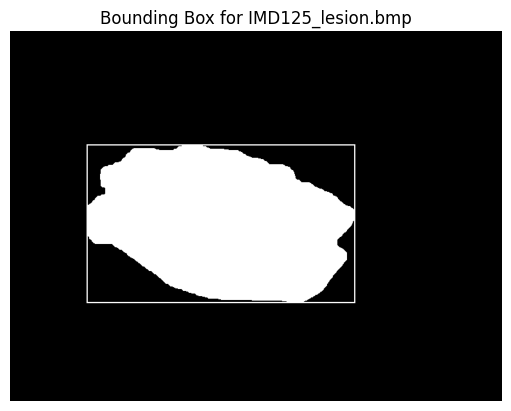

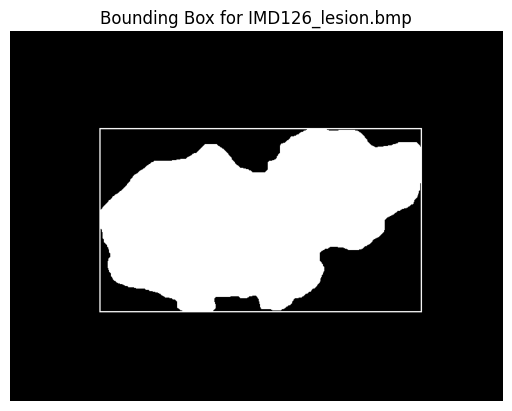

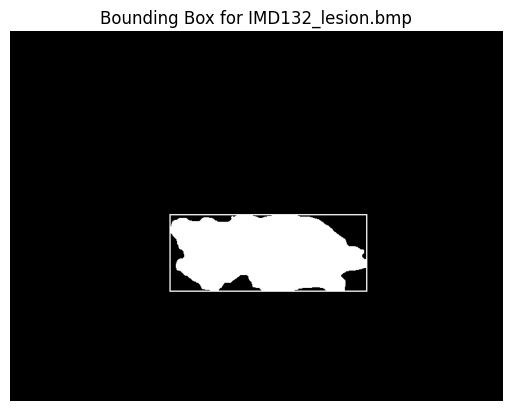

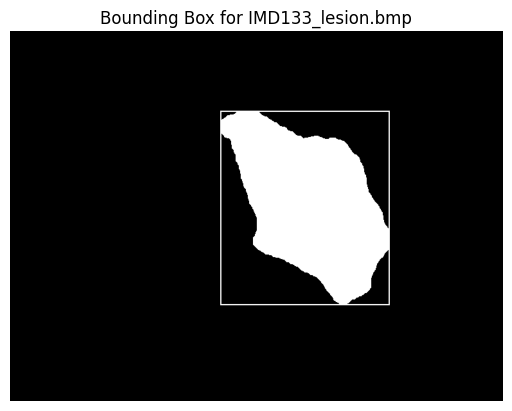

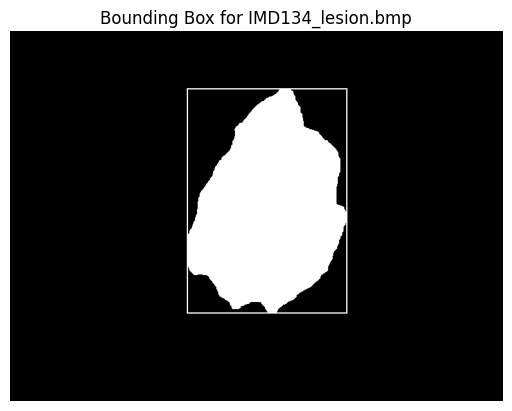

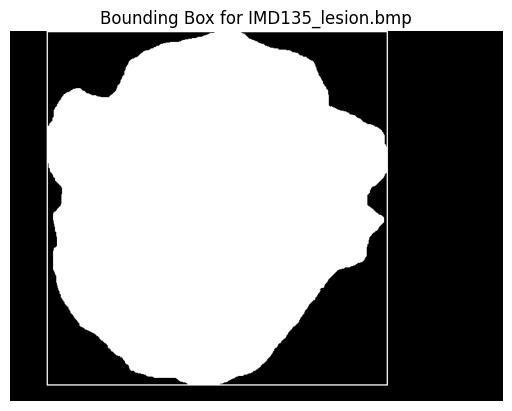

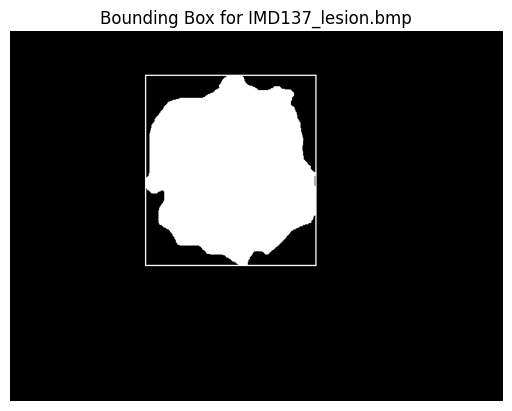

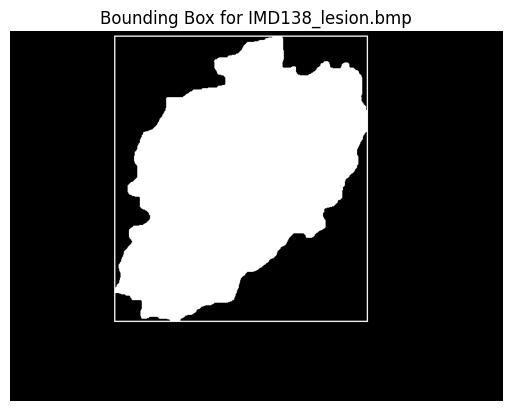

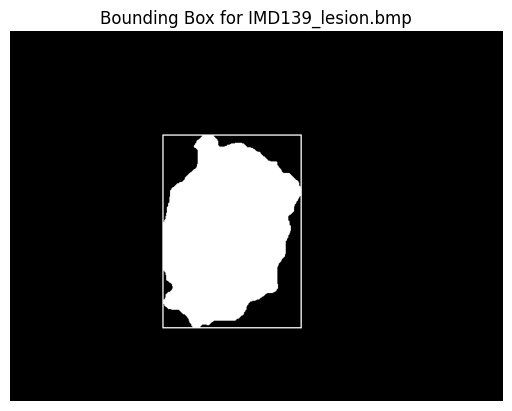

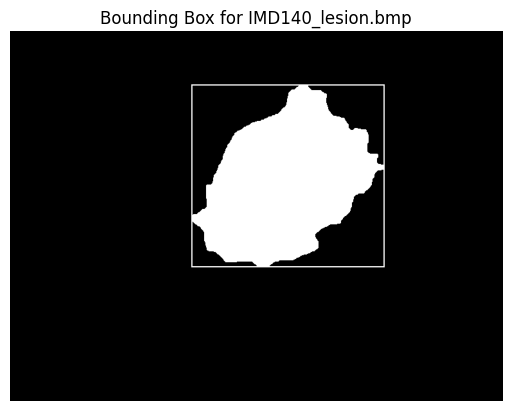

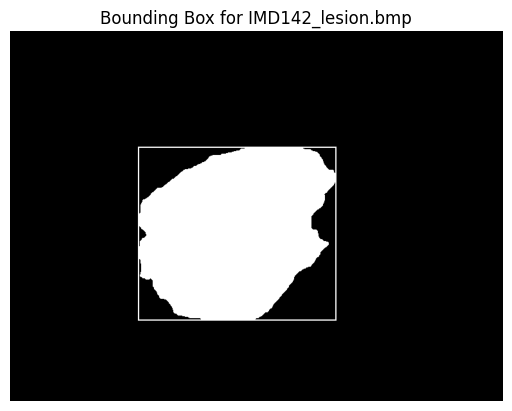

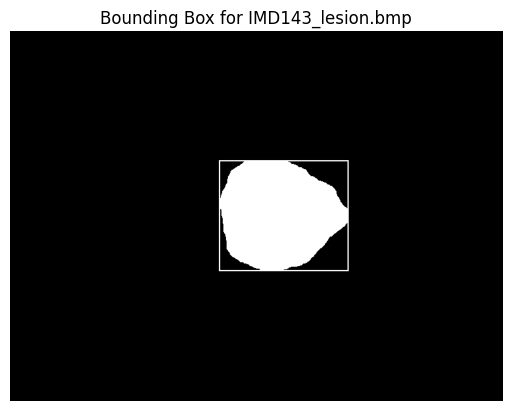

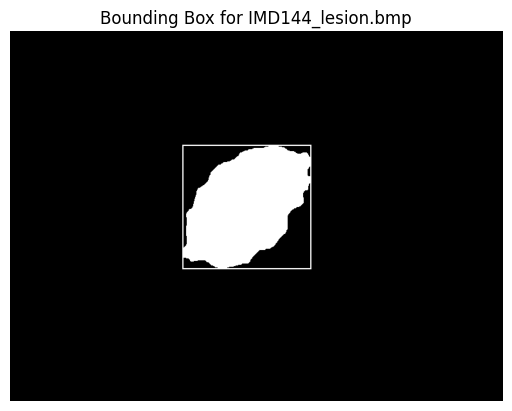

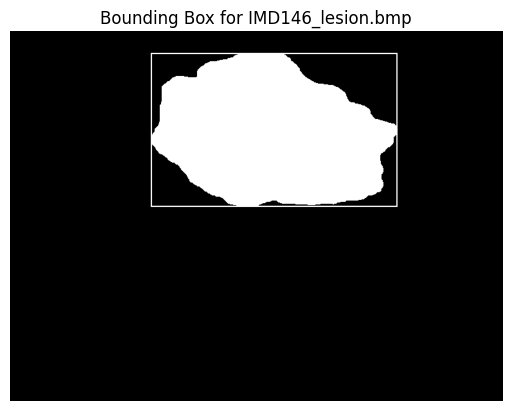

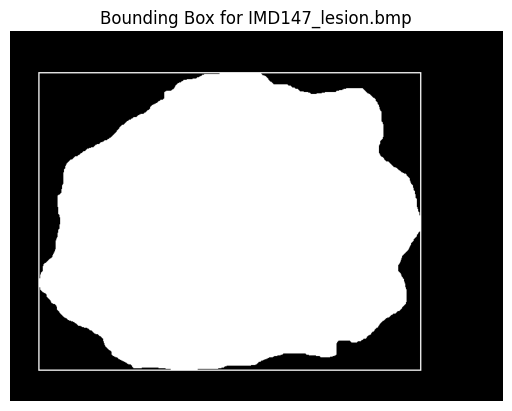

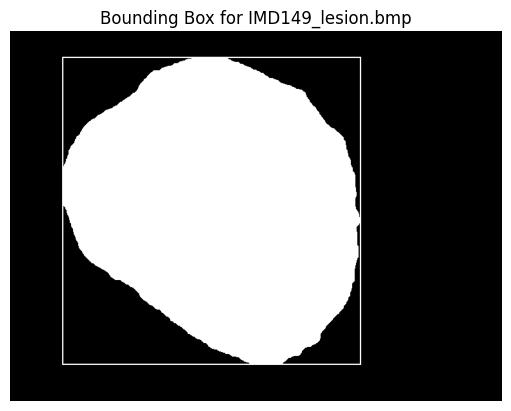

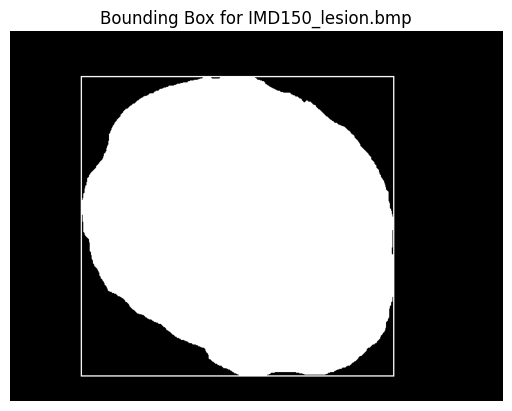

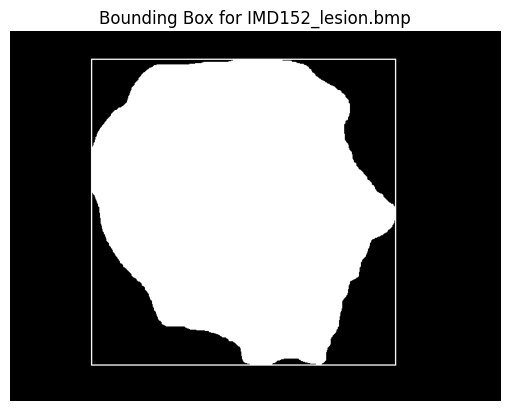

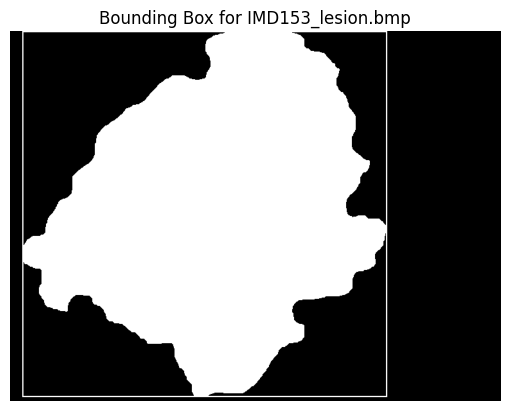

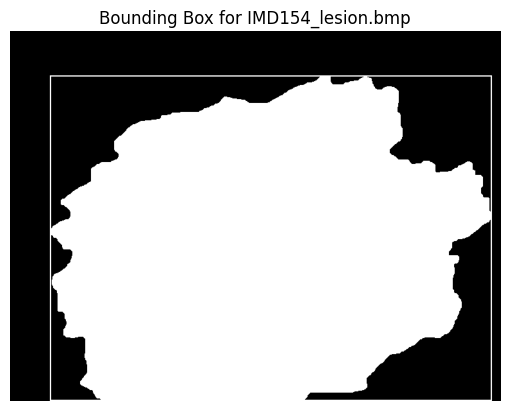

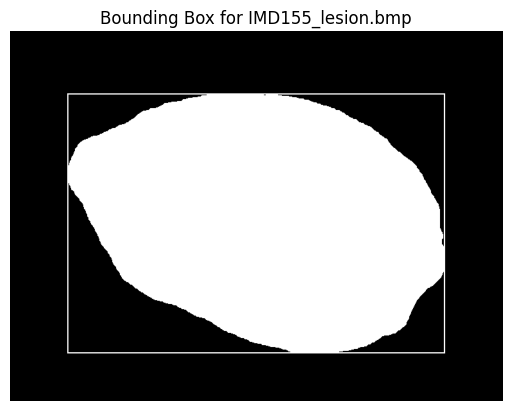

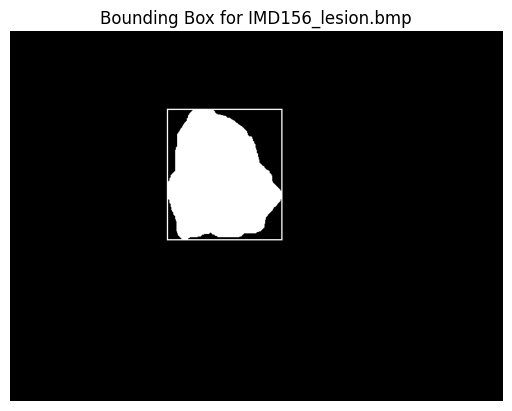

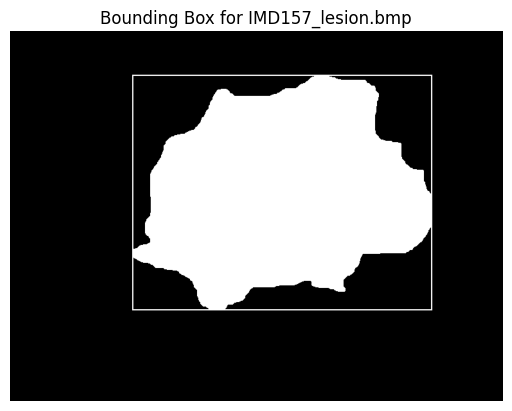

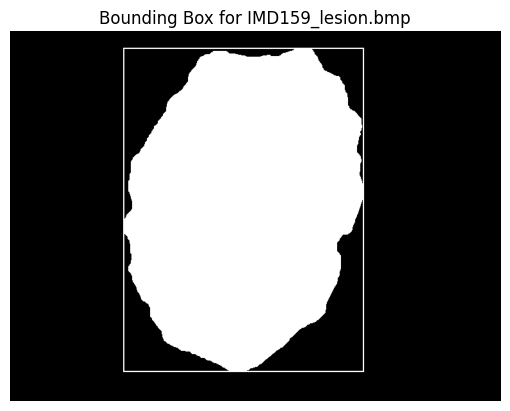

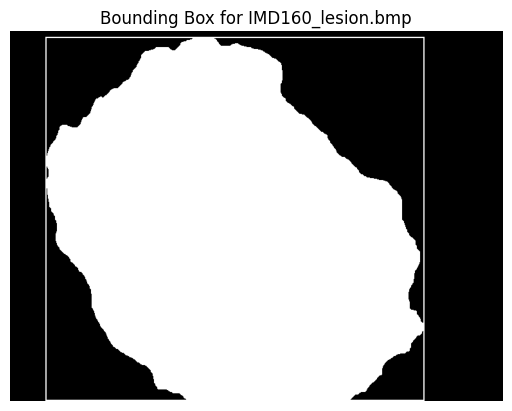

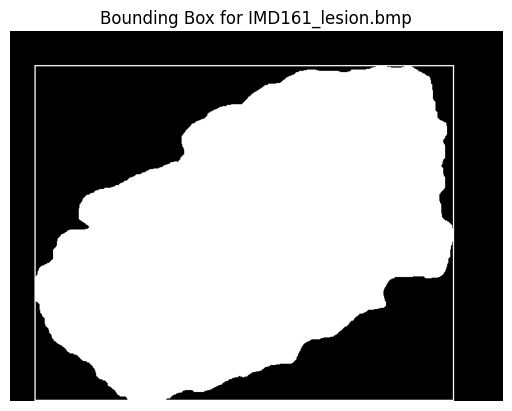

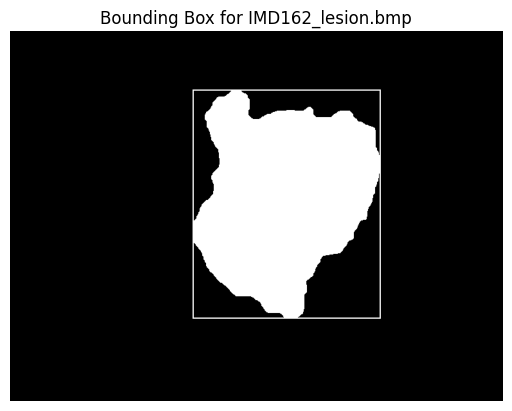

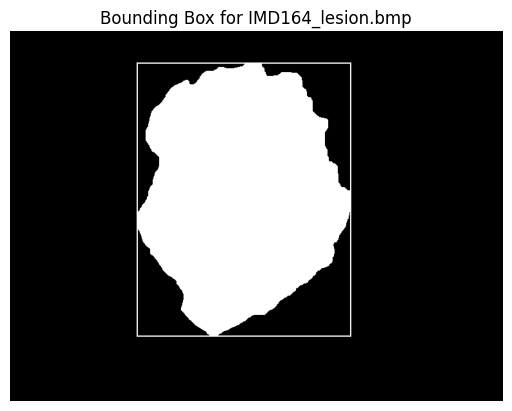

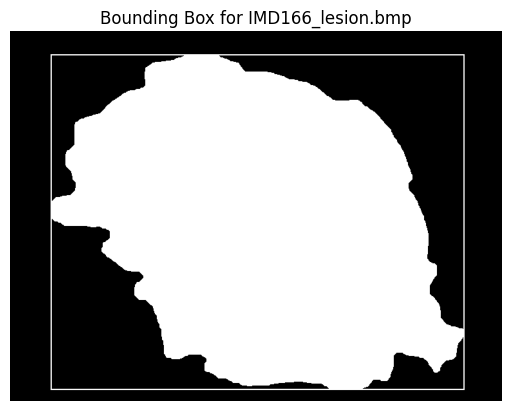

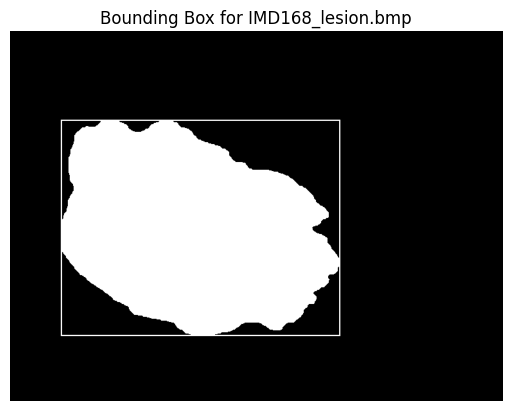

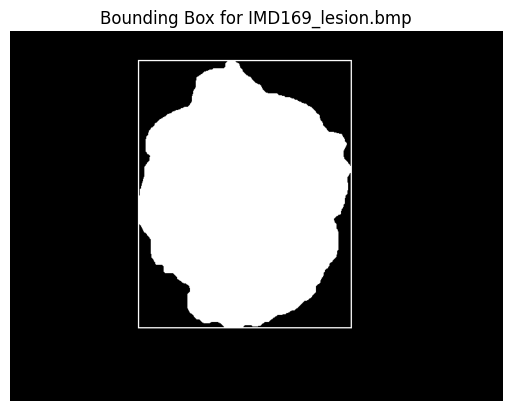

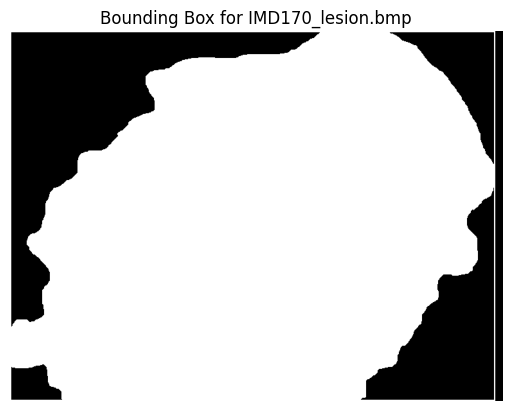

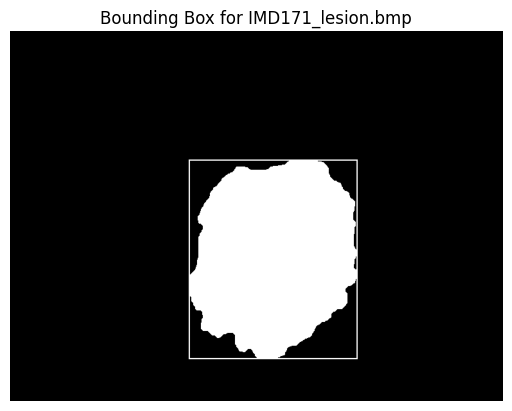

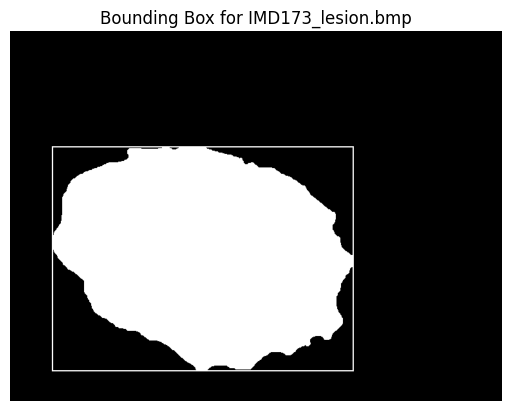

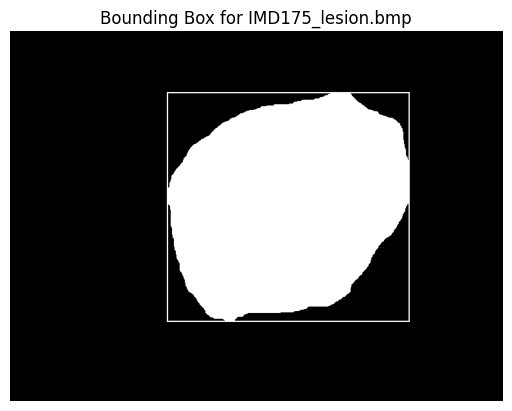

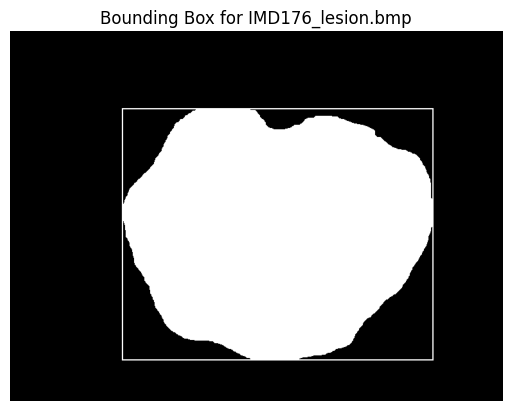

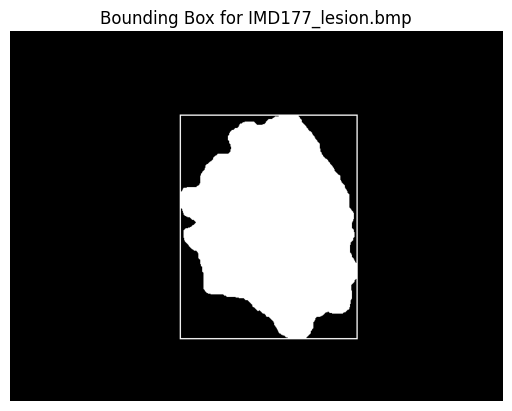

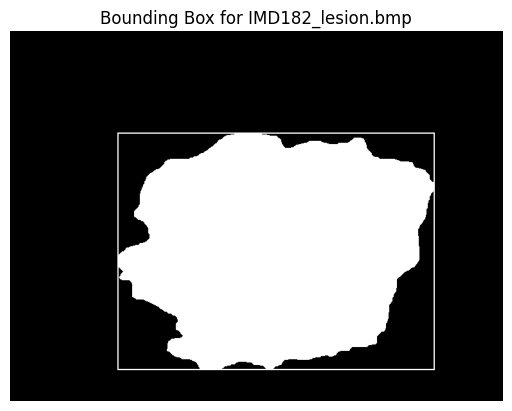

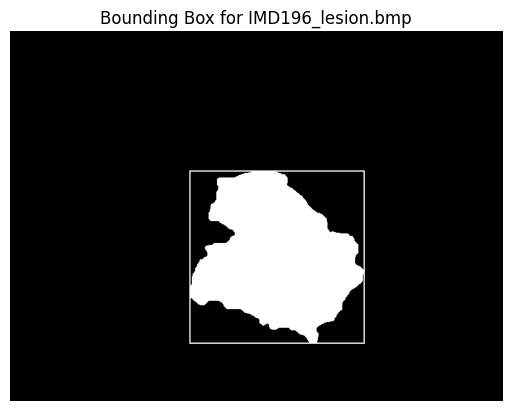

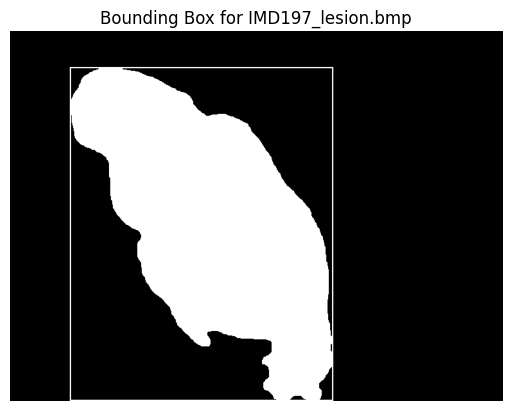

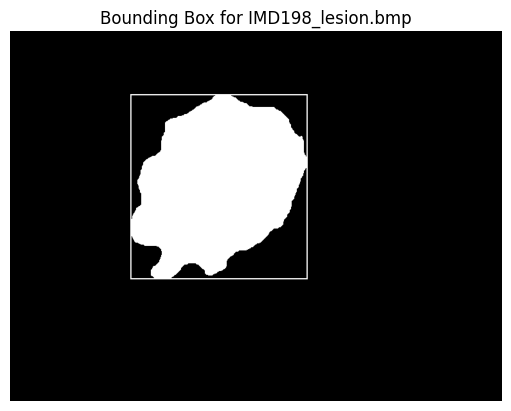

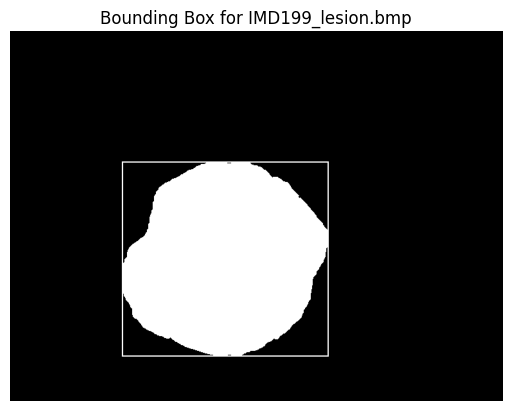

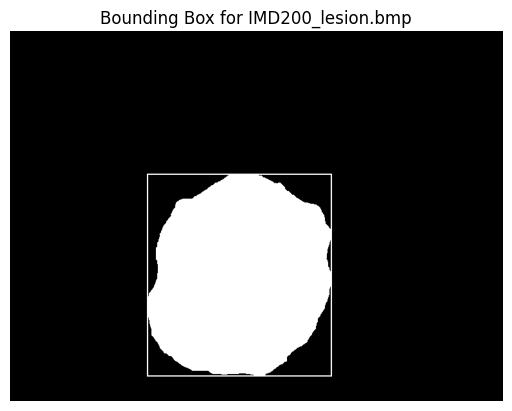

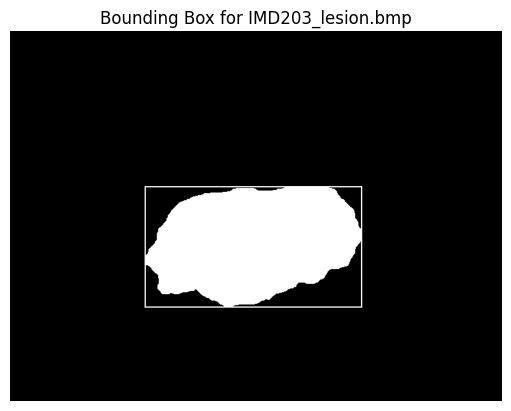

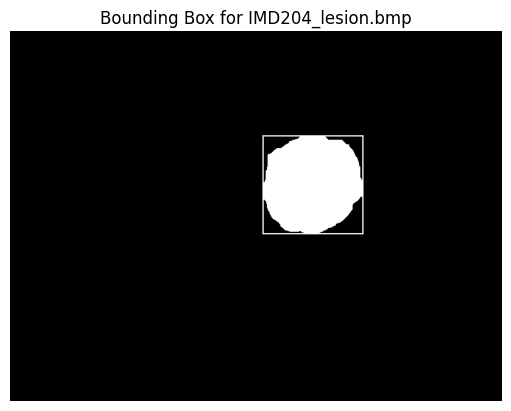

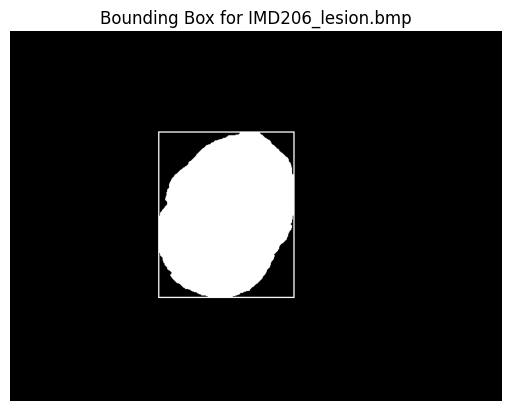

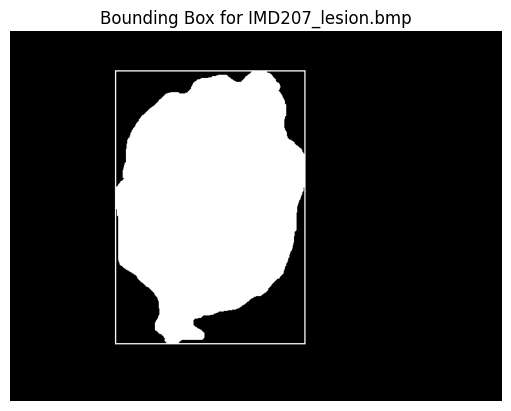

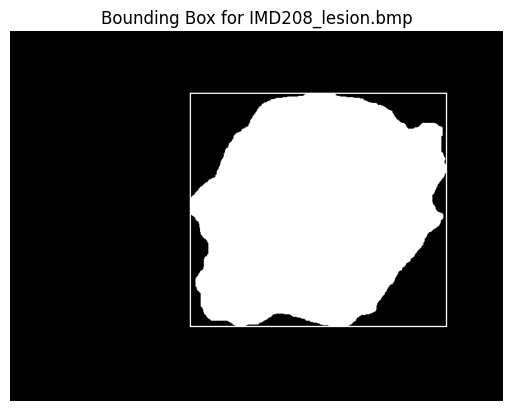

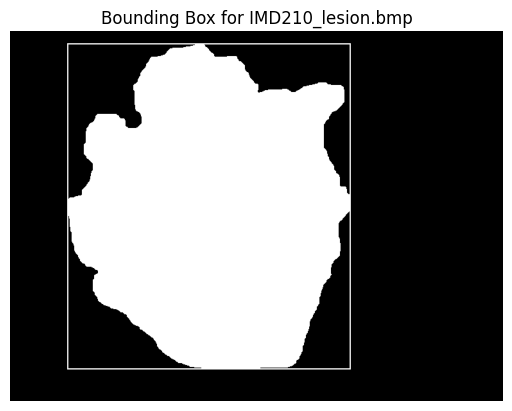

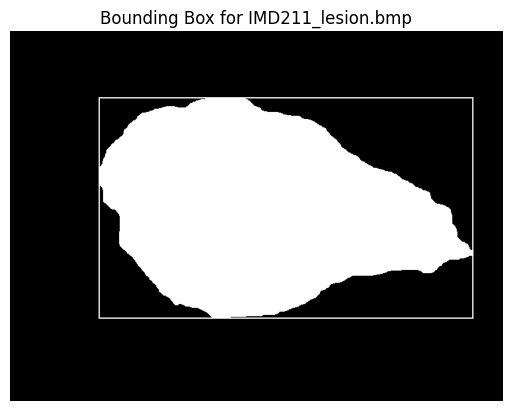

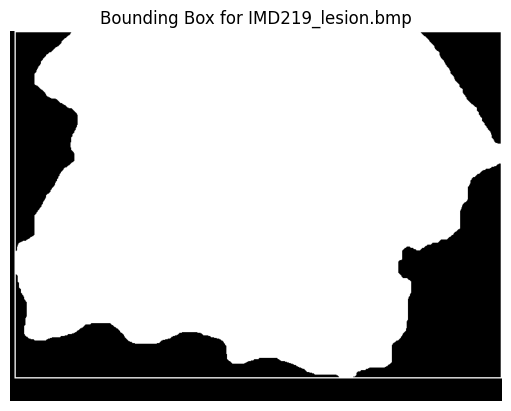

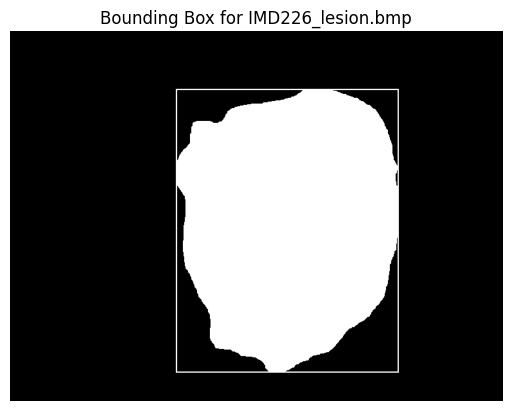

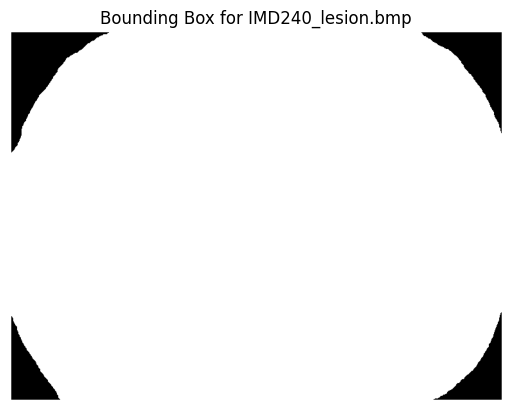

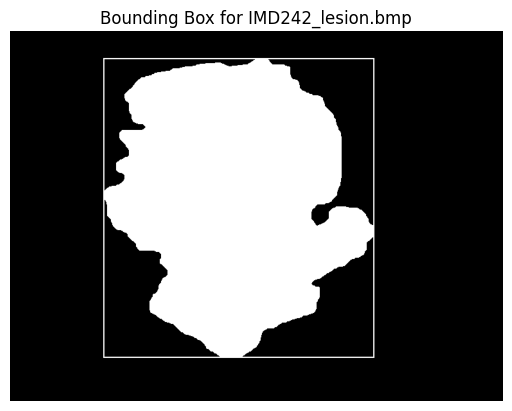

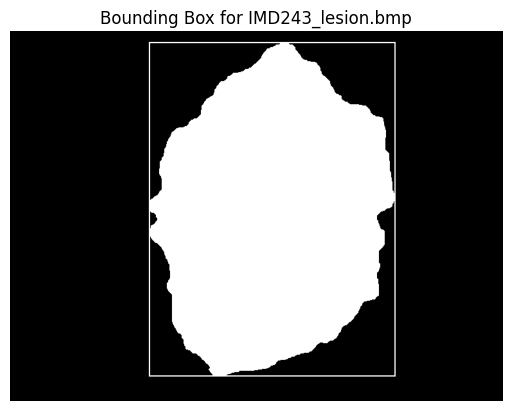

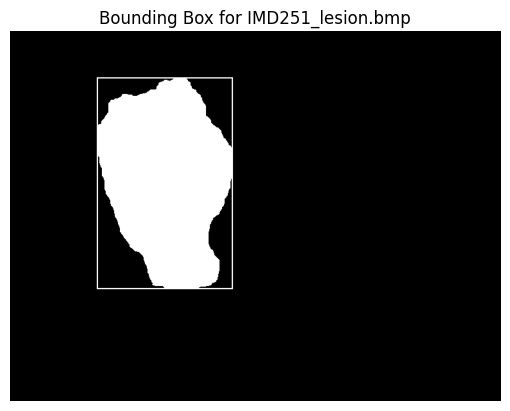

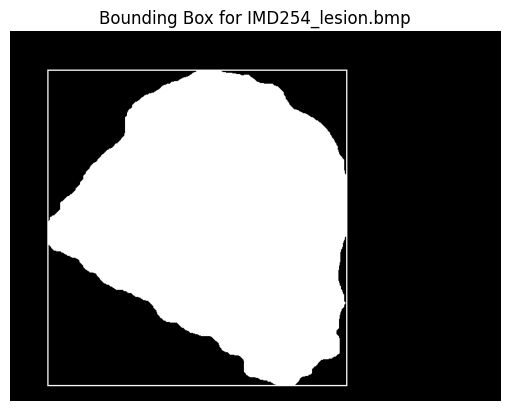

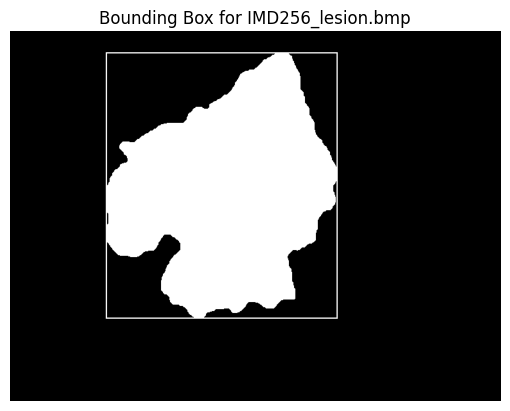

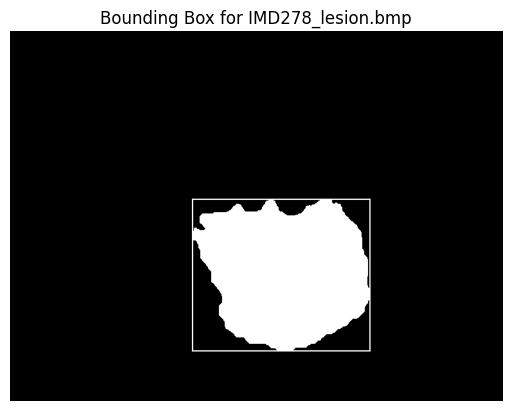

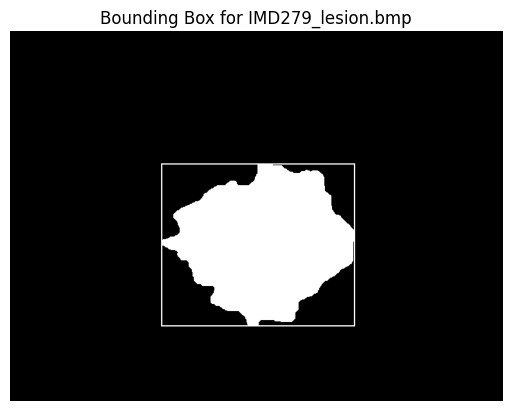

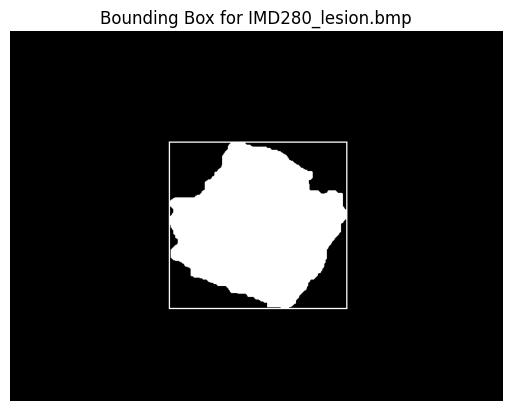

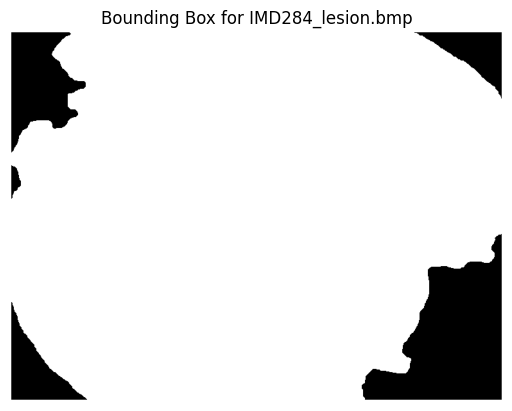

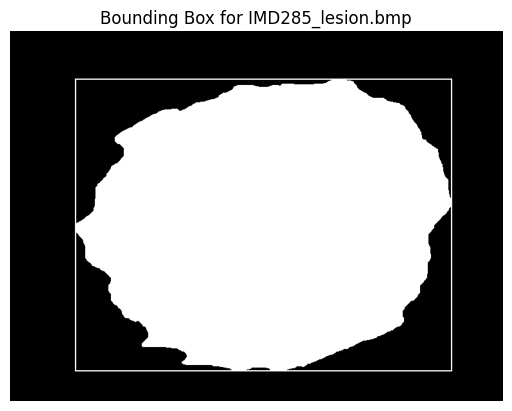

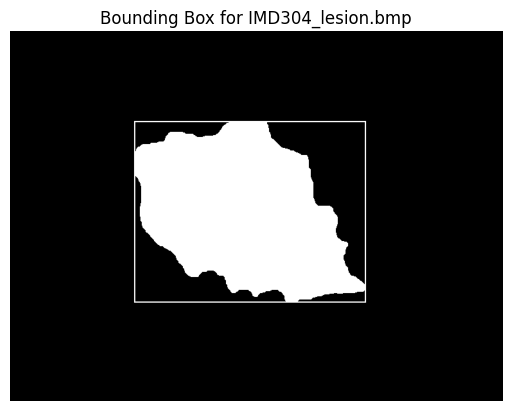

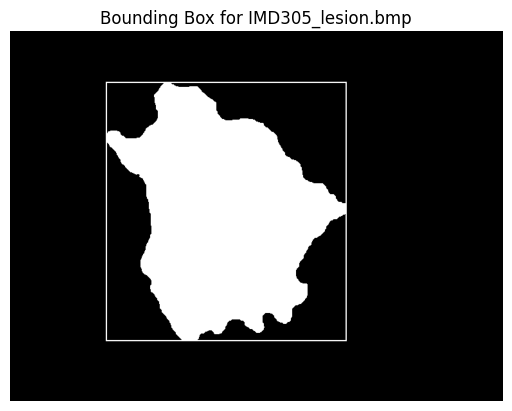

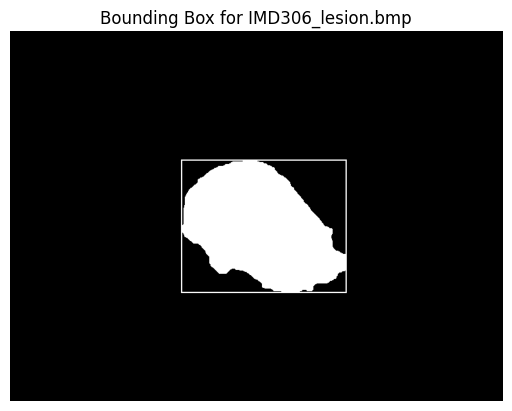

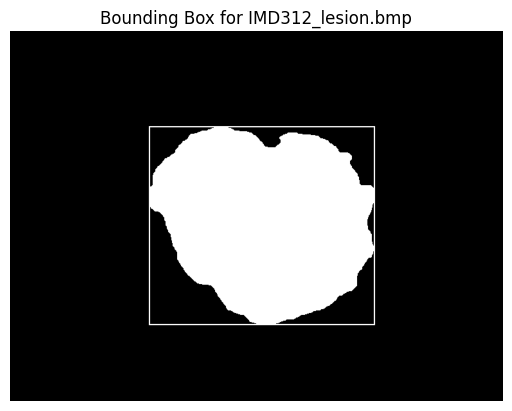

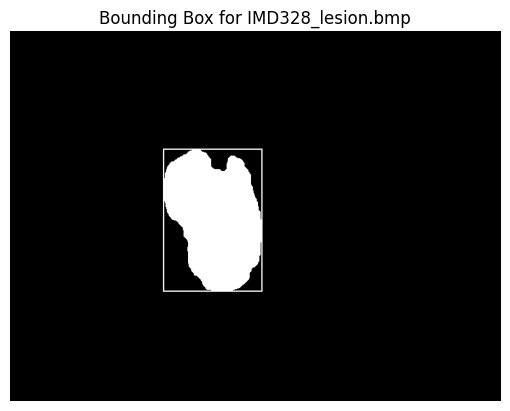

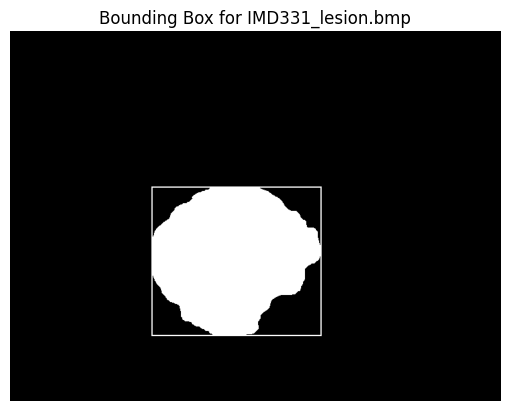

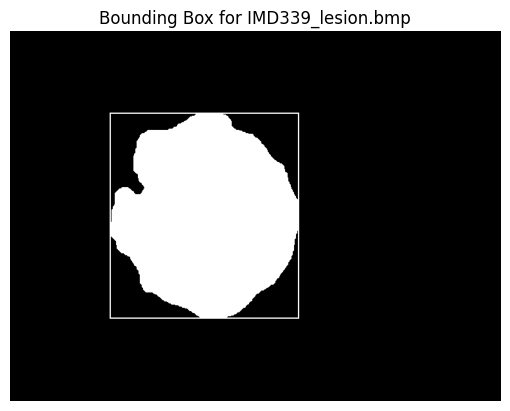

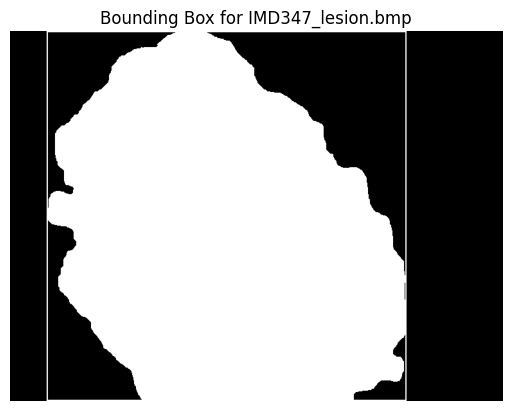

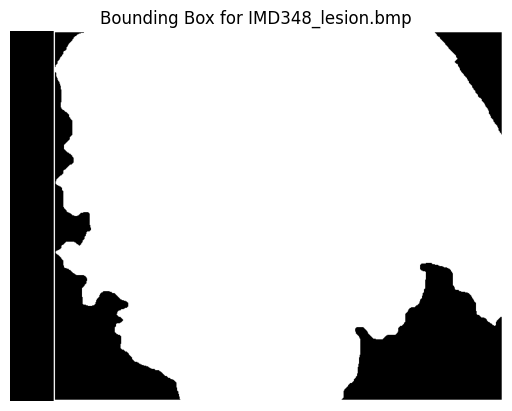

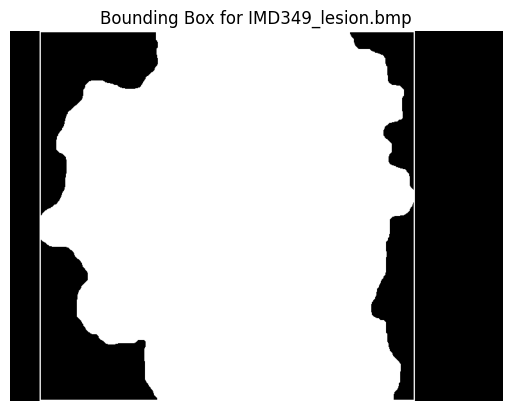

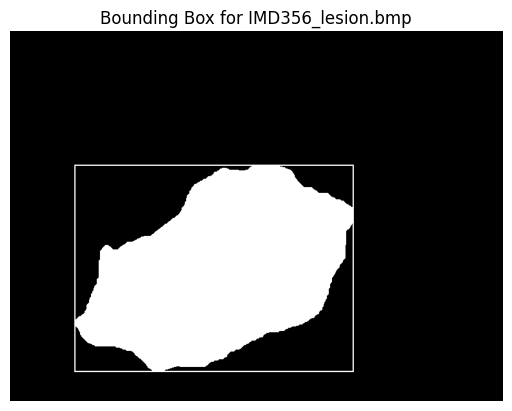

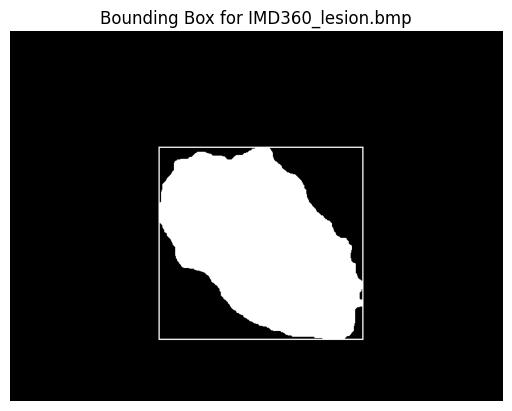

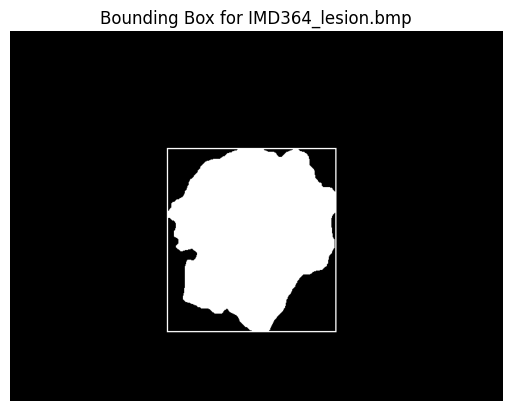

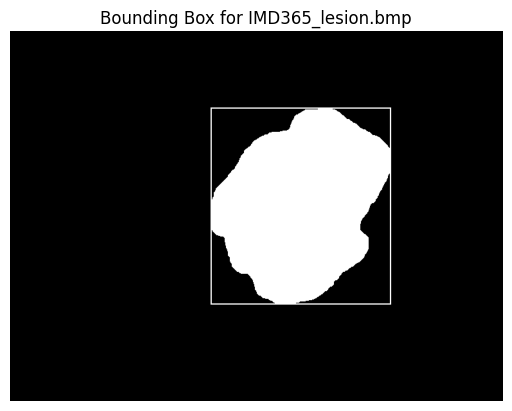

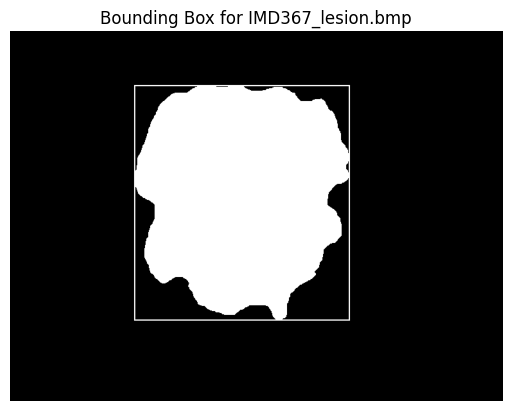

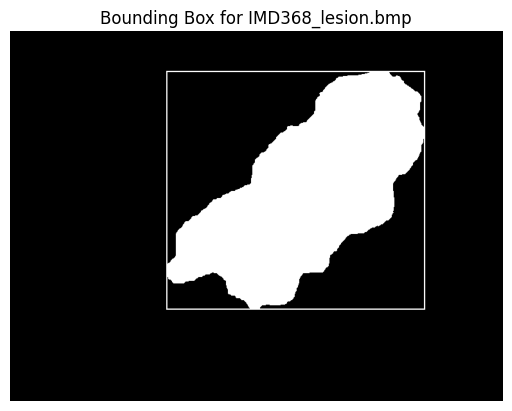

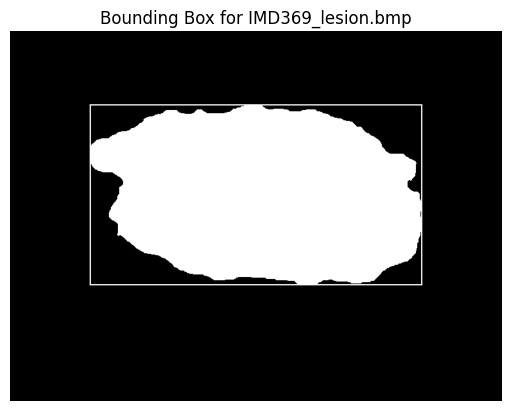

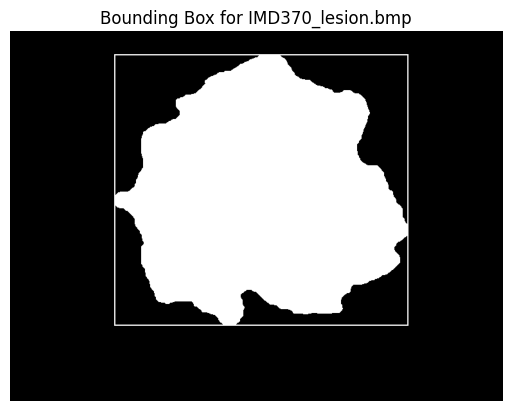

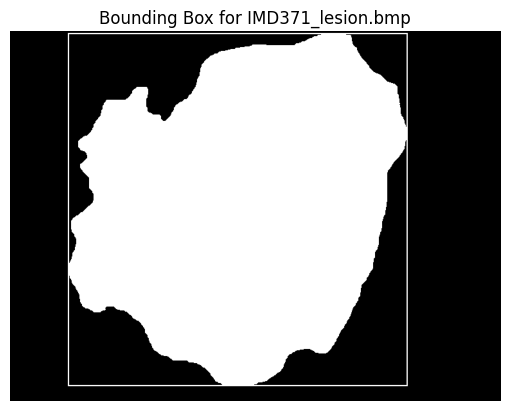

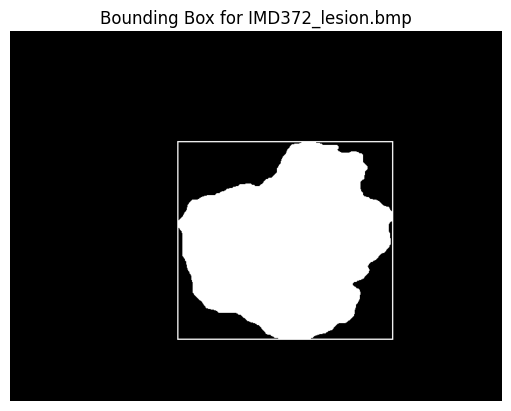

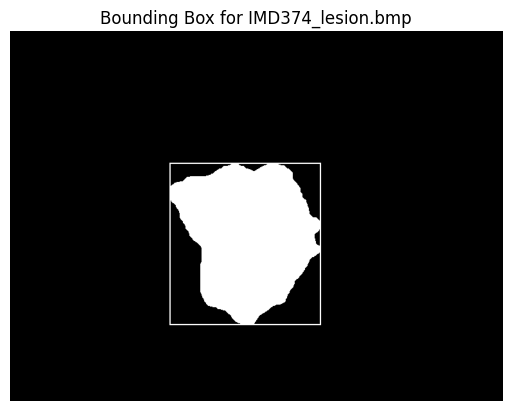

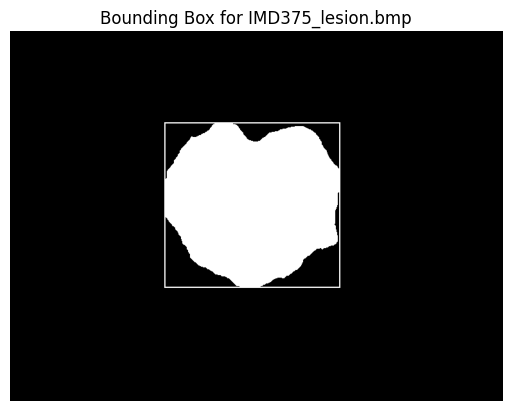

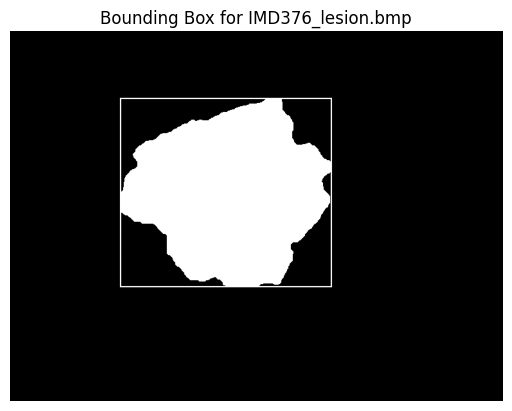

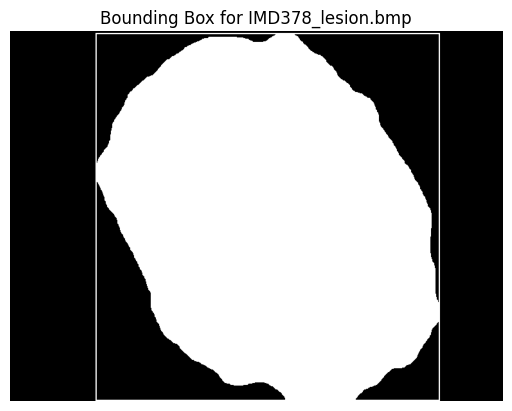

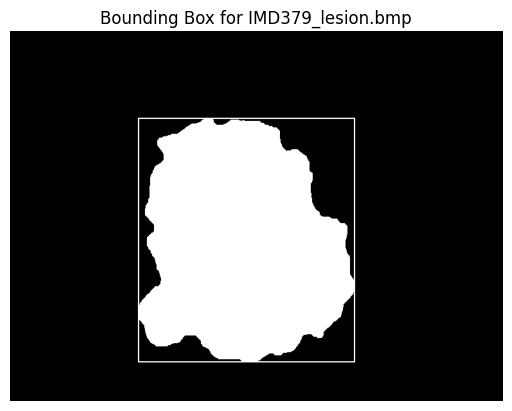

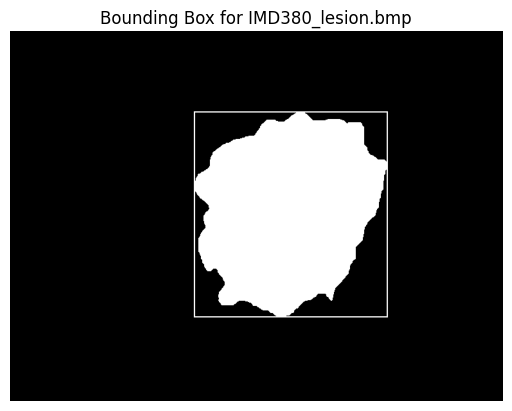

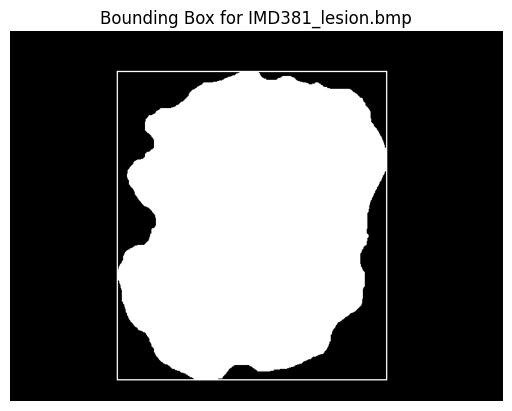

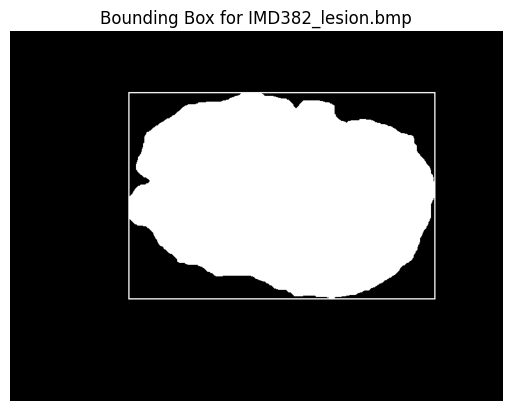

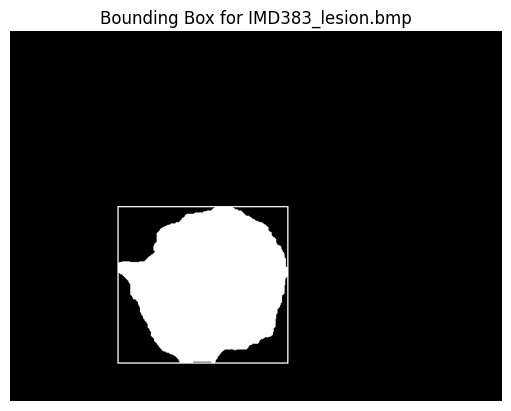

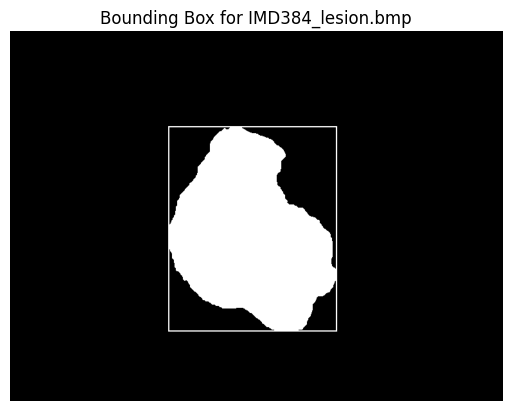

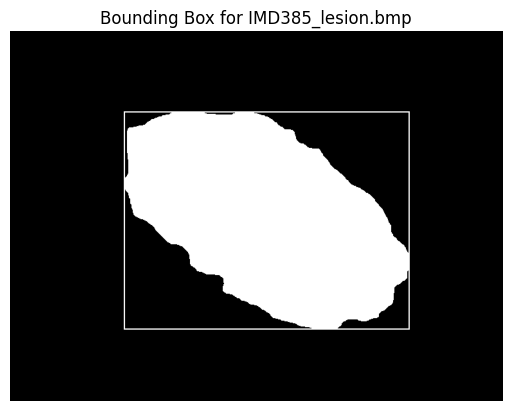

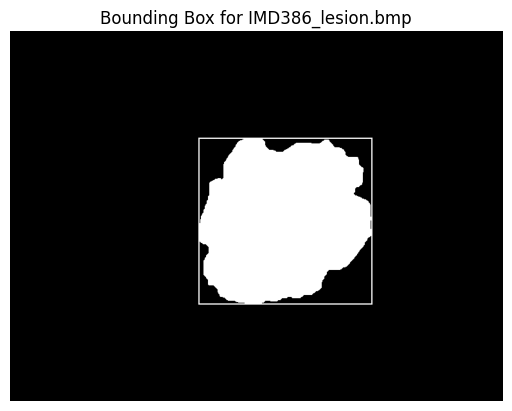

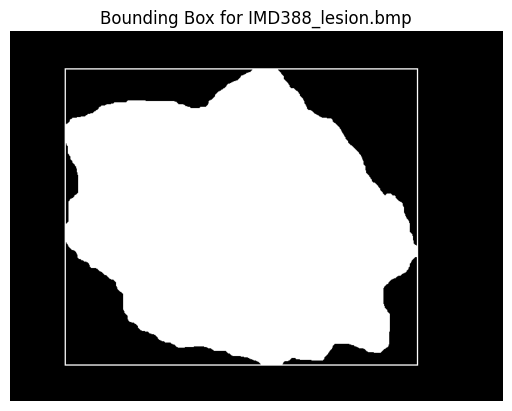

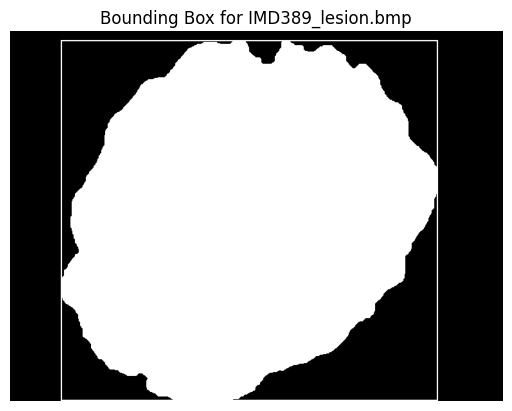

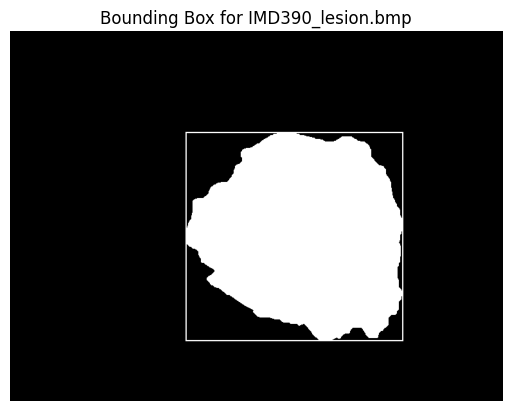

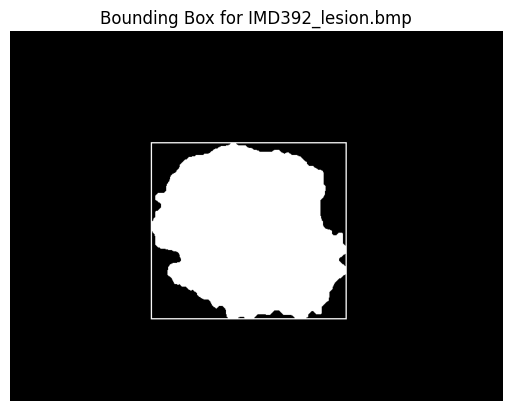

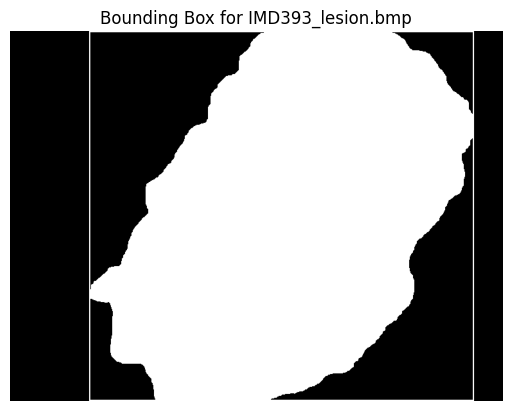

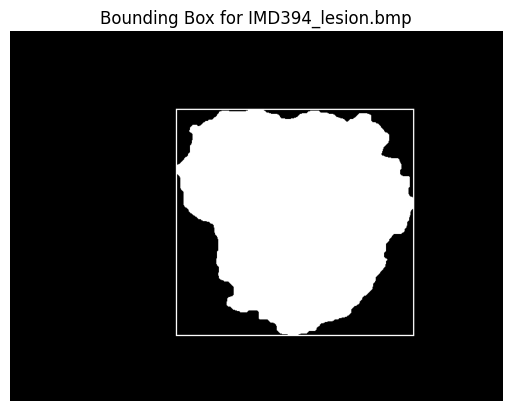

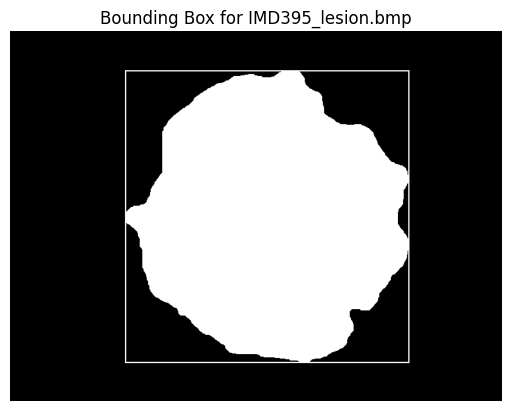

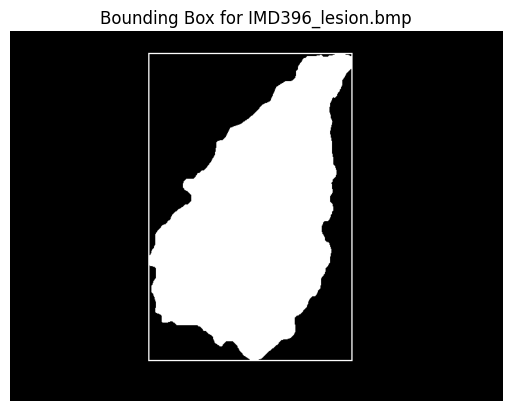

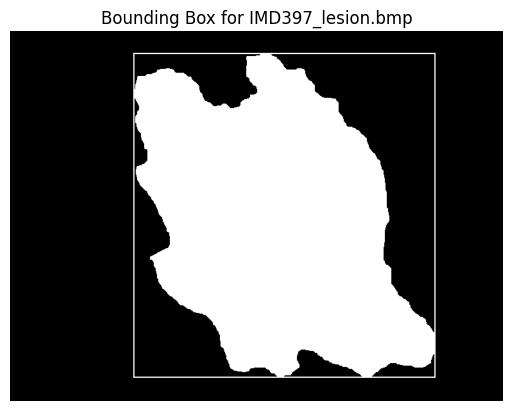

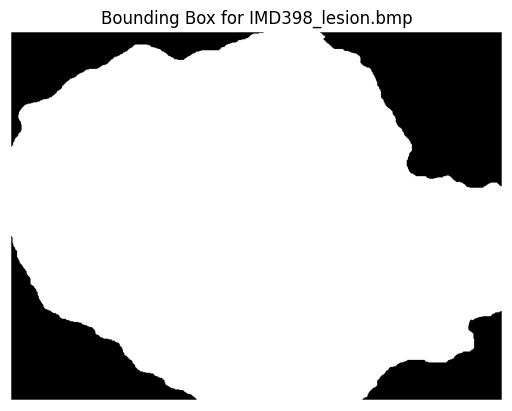

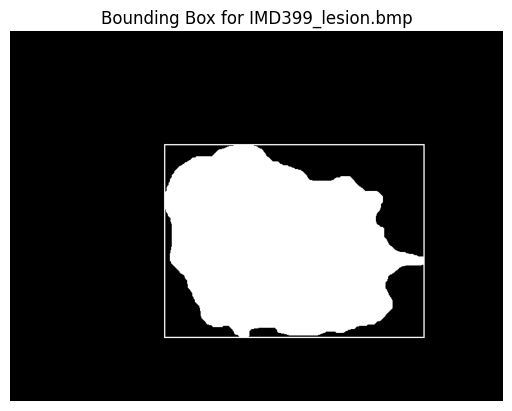

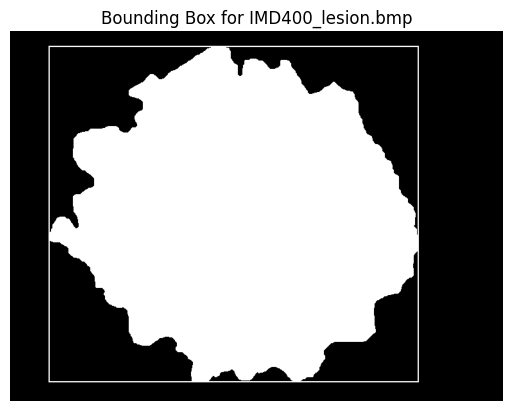

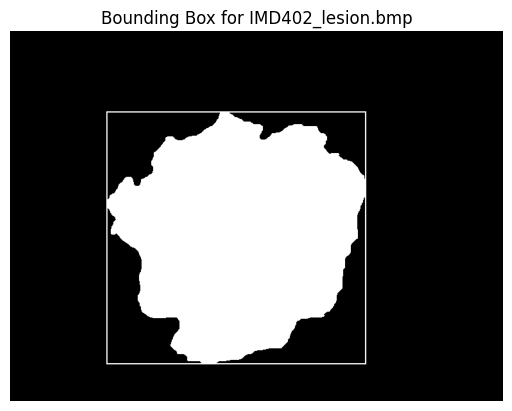

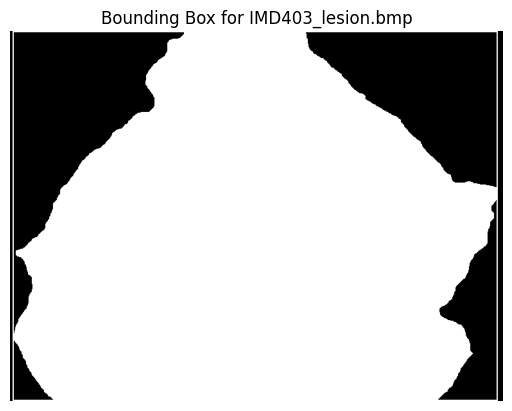

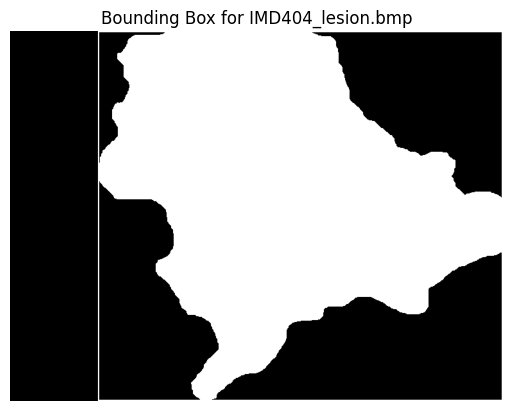

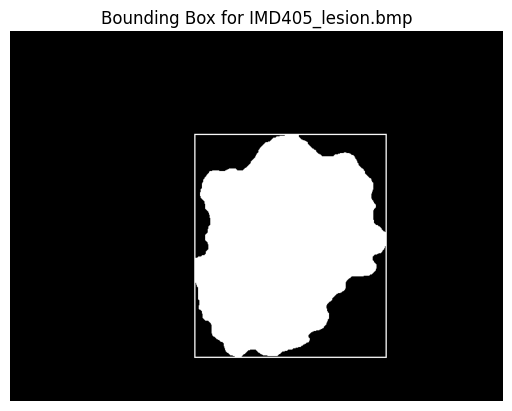

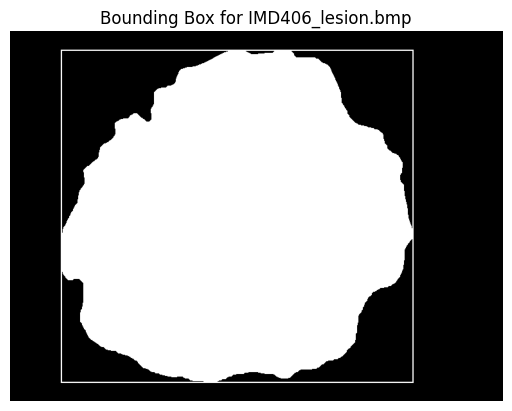

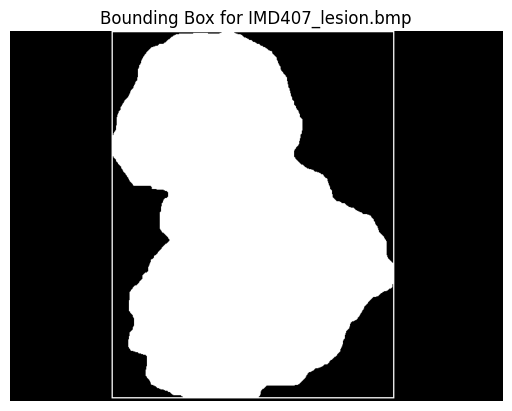

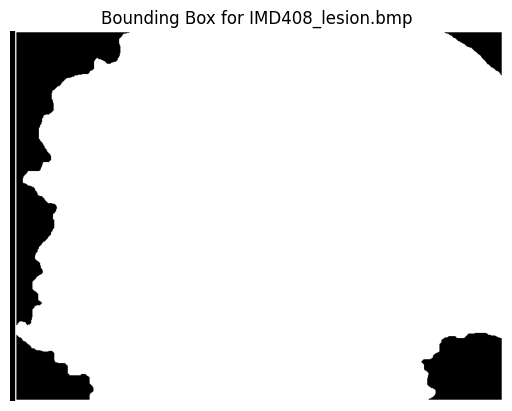

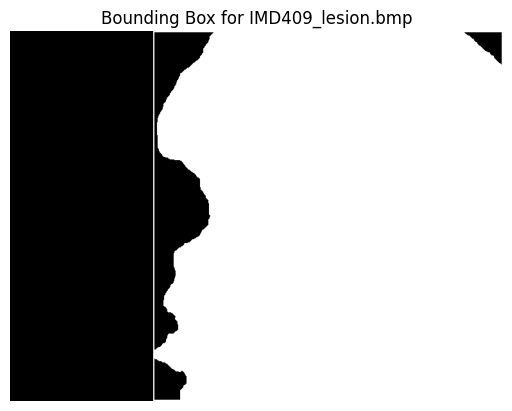

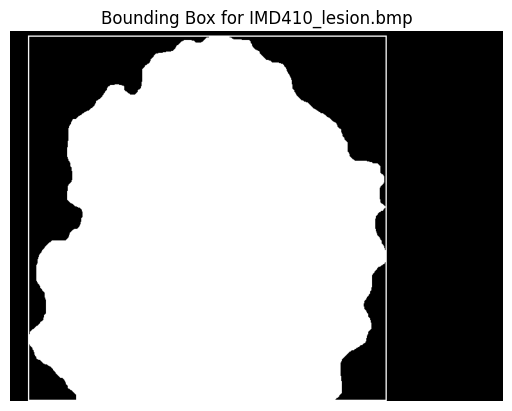

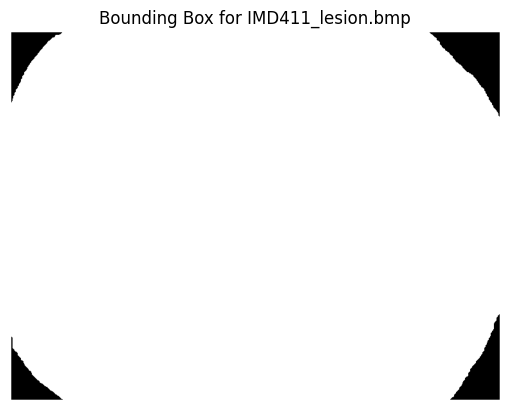

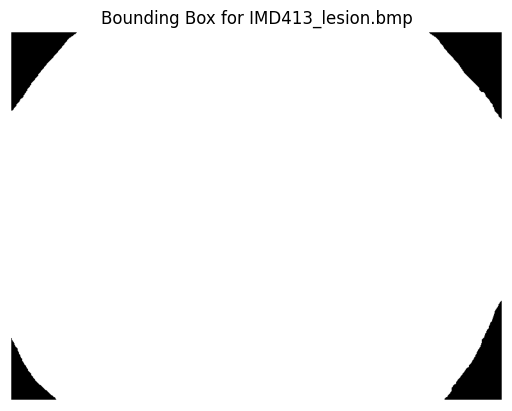

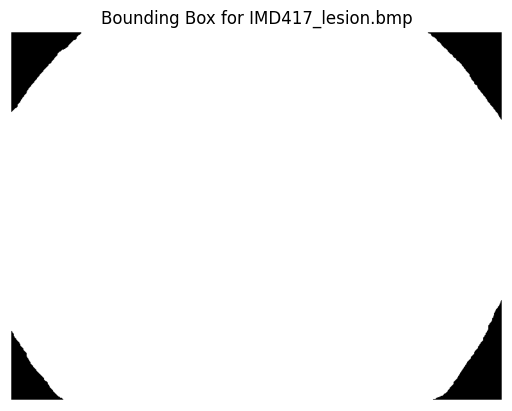

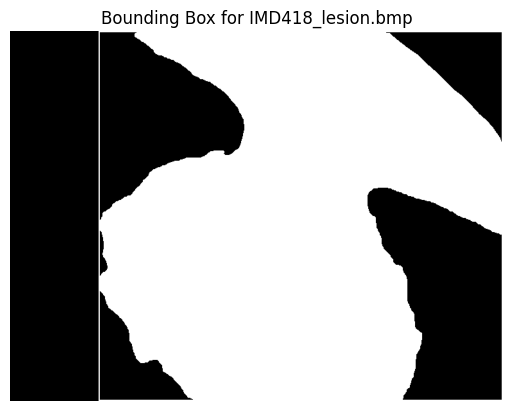

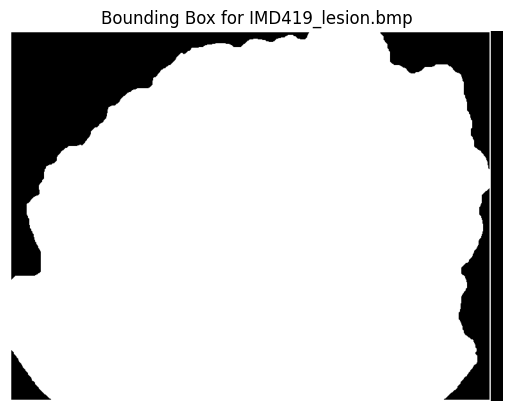

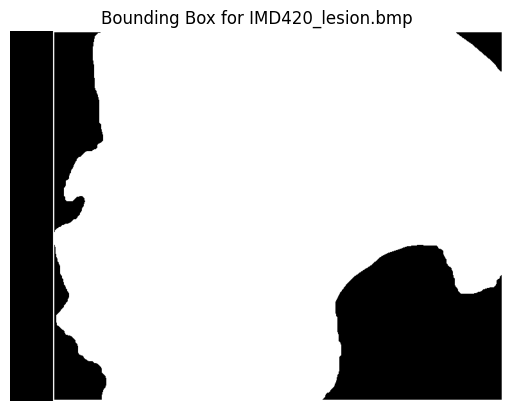

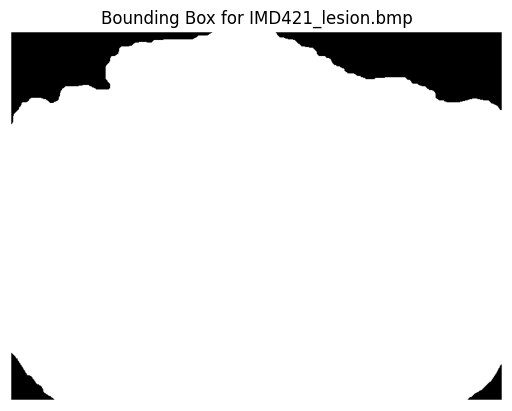

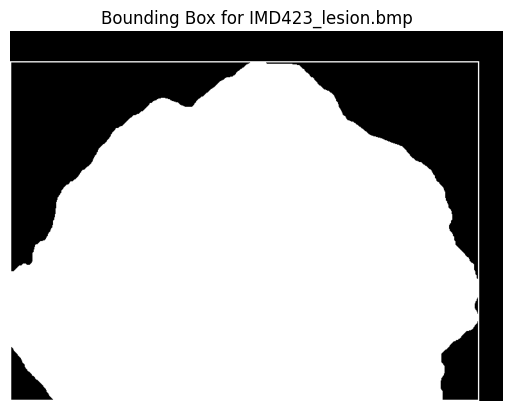

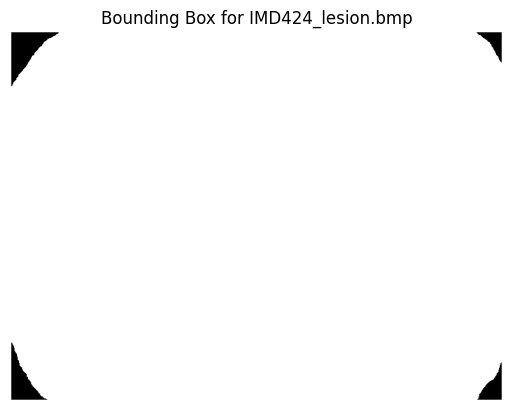

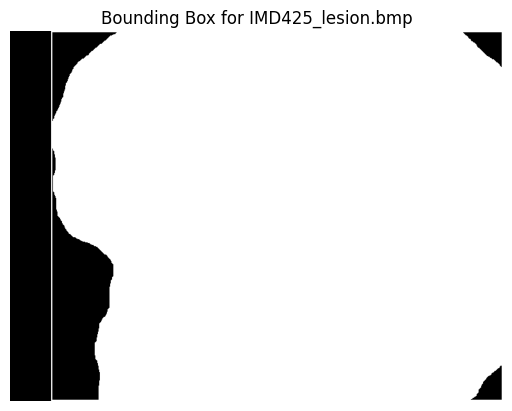

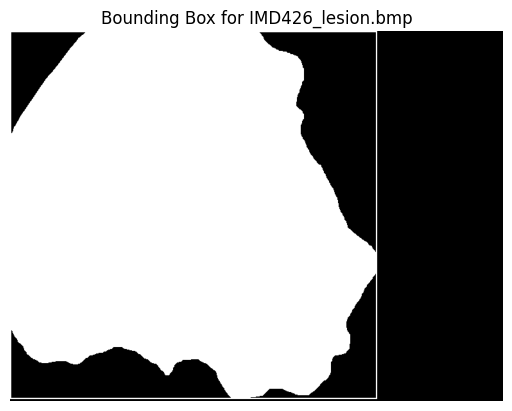

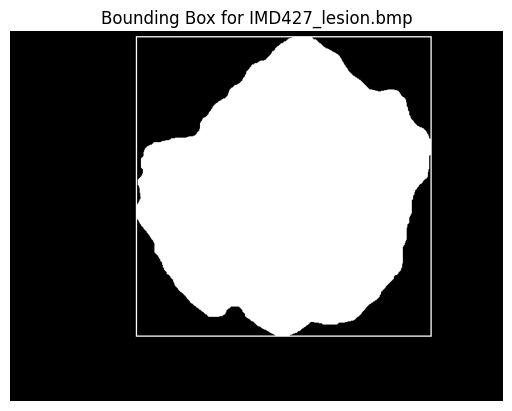

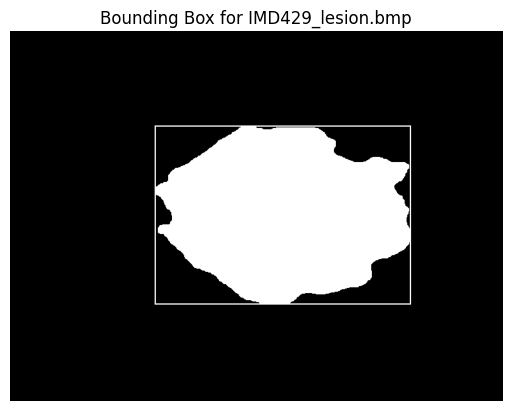

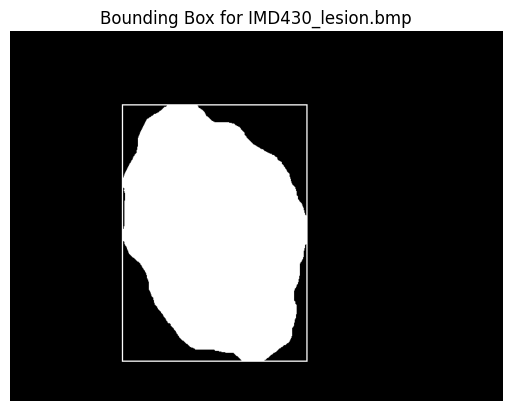

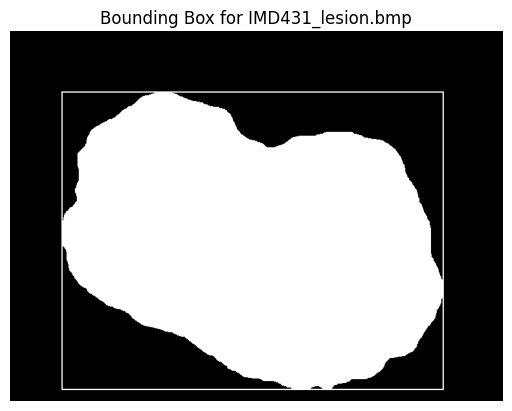

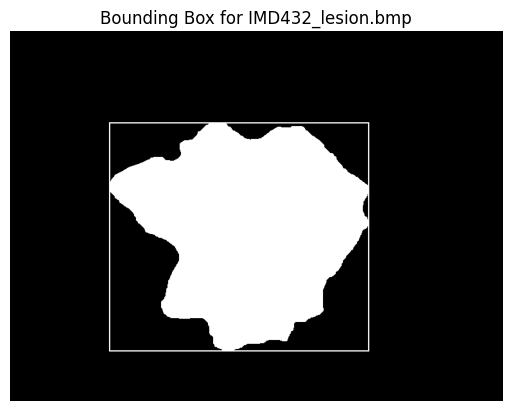

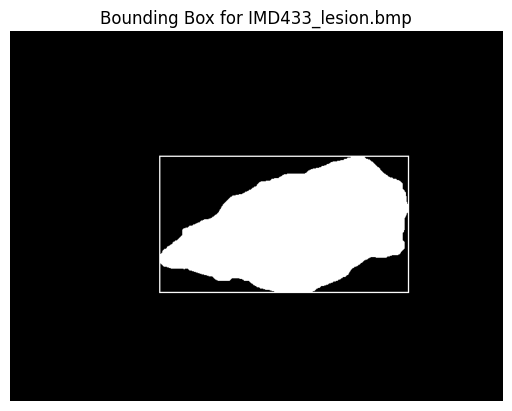

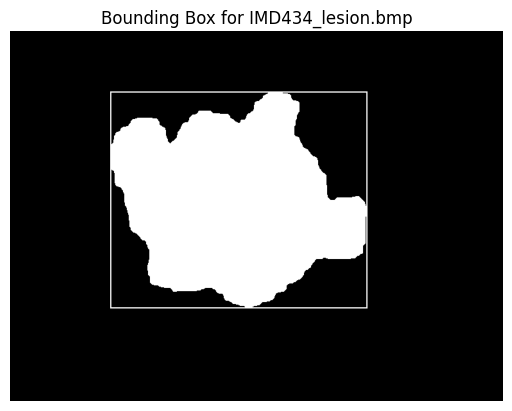

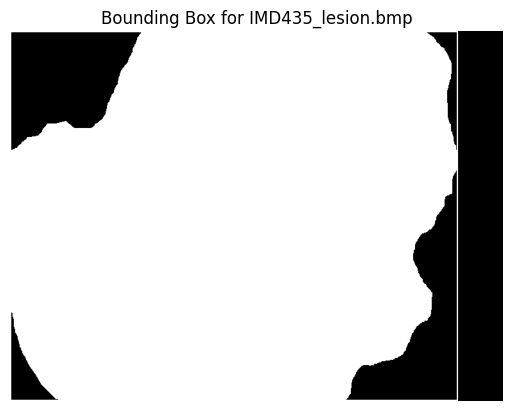

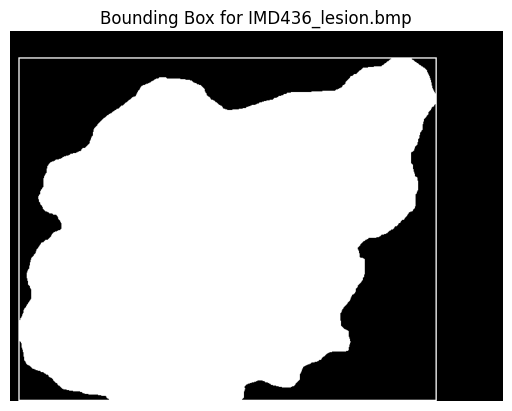

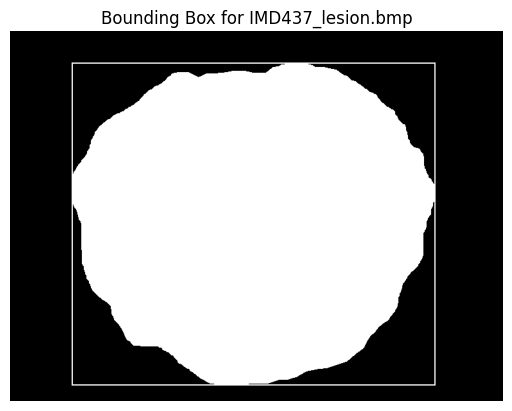

In [59]:
# 1. Load images from path pattern
image_paths = glob.glob(pattern)

# 2. Read image, get bounding box coordinates, and visualize
bounding_boxes = []
for image_path in image_paths:
    # 2.1 Read & resize image
    image = Image.open(image_path)
    image_np = np.array(image)
    if resize_dim is not None:
        resize_transform = transforms.Resize(resize_dim, interpolation=InterpolationMode.NEAREST)
        resized_binary_mask = resize_transform(image)
        image_np = np.array(resized_binary_mask)

    # 2.2 Get bounding box coordinates using weak_annotator
    bounding_boxes_for_given_image = weak_annotator.image_to_bounding_box(image_np)
    relative_path = os.path.relpath(image_path, start=base_path)
    for min_x, min_y, max_x, max_y in bounding_boxes_for_given_image:
        bounding_boxes.append({
            "image_path": relative_path,
            "min_x": min_x,
            "min_y": min_y,
            "max_x": max_x,
            "max_y": max_y
        })

        # 2.3 Visualize bounding box on the image
        image_pil = Image.fromarray(image_np)
        draw = ImageDraw.Draw(image_pil)
        draw.rectangle([min_x, min_y, max_x, max_y], outline="red", width=2)
        plt.imshow(image_pil)
        plt.title(f'Bounding Box for {os.path.basename(image_path)}')
        plt.axis('off')
        plt.show()


In [60]:
# 3. Export data to csv
box_df = pd.DataFrame(bounding_boxes)

# 4. Save the DataFrame
box_df.to_csv("bounding_boxes.csv", index=False)

box_df

,image_path,min_x,min_y,max_x,max_y
0,IMD002\IMD002_lesion\IMD002_lesion.bmp,239,85,616,518
1,IMD003\IMD003_lesion\IMD003_lesion.bmp,172,127,425,408
2,IMD004\IMD004_lesion\IMD004_lesion.bmp,158,120,510,483
3,IMD006\IMD006_lesion\IMD006_lesion.bmp,367,118,672,505
4,IMD008\IMD008_lesion\IMD008_lesion.bmp,259,136,555,408
...,...,...,...,...,...
195,IMD433\IMD433_lesion\IMD433_lesion.bmp,232,194,620,407
196,IMD434\IMD434_lesion\IMD434_lesion.bmp,156,94,556,431
197,IMD435\IMD435_lesion\IMD435_lesion.bmp,0,0,697,575
198,IMD436\IMD436_lesion\IMD436_lesion.bmp,13,41,663,575


## 3. Region growing

In [9]:
# 0. Initialization
image_base_path = r'C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fall\02516 - Intro 2 DL in CV\Projects\Project 3\PH2_Dataset_images'
point_data_folder = r'../point_data/2point/'

output_region_growing_masks = r'../region_growing_masks/2point/'

In [10]:
# 1. Organize data
data = []

for file_name in os.listdir(point_data_folder):
    if file_name.endswith('.npy'):
        # 1.1 Extract the Image file name identifier
        identifier = file_name.split('_')[0]  
        
        # 2. Construct file paths
        point_annotation_path = os.path.join(point_data_folder, file_name)
        image_path = os.path.join(base_path, identifier, f'{identifier}_Dermoscopic_Image', f'{identifier}.bmp')
        
        # 3. Append the data to the list
        data.append({
            'identifier': identifier,
            'image_path': image_path,
            'point_annotation_path': point_annotation_path
        })

df = pd.DataFrame(data)
df

,identifier,image_path,point_annotation_path
0,IMD002,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD002_points.npy
1,IMD003,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD003_points.npy
2,IMD004,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD004_points.npy
3,IMD006,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD006_points.npy
4,IMD008,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD008_points.npy
...,...,...,...
195,IMD433,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD433_points.npy
196,IMD434,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD434_points.npy
197,IMD435,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD435_points.npy
198,IMD436,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/2point/IMD436_points.npy


In [11]:
# Iterate through each image and generate masks
masks = []
for _, row in df.iterrows():
    # 1. Fetch images and point annotations
    image_path = row["image_path"]
    point_annotation_path = row["point_annotation_path"]
    
    image = io.imread(image_path, as_gray=True)
    image_np = np.array(image)
    points = np.load(point_annotation_path)
    seeds = [(int(point[1]), int(point[0])) for point in points]  
    
    # 2. Generate mask using region growing
    mask = weak_annotator.region_growing(image_np, seeds)
    masks.append(mask)
    
    # plt.imshow(mask, cmap='gray')
    # plt.title("Generated Mask")
    # plt.show()

    # 3. Save the mask
    mask_filename = os.path.basename(image_path).replace(".bmp", "_mask.bmp")
    mask_path = os.path.join(output_region_growing_masks, mask_filename)  
    print(f'Saving mask to: {mask_path}') 
    plt.imsave(mask_path, mask, cmap="gray")

Mask unique values: [0 1]
Foreground pixel count: 315889
Background pixel count: 121691
Saving mask to: ../region_growing_masks/2point/IMD002_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 320091
Background pixel count: 119019
Saving mask to: ../region_growing_masks/2point/IMD003_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 304765
Background pixel count: 134345
Saving mask to: ../region_growing_masks/2point/IMD004_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 347375
Background pixel count: 91735
Saving mask to: ../region_growing_masks/2point/IMD006_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 265974
Background pixel count: 175242
Saving mask to: ../region_growing_masks/2point/IMD008_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 198923
Background pixel count: 241527
Saving mask to: ../region_growing_masks/2point/IMD009_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 205916
Background pixel count: 232429
Saving 

In [12]:
# 0. Initialization
image_base_path = r'C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fall\02516 - Intro 2 DL in CV\Projects\Project 3\PH2_Dataset_images'
point_data_folder = r'../point_data/4point/'

output_region_growing_masks = r'../region_growing_masks/4point/'

In [13]:
# 1. Organize data
data = []

for file_name in os.listdir(point_data_folder):
    if file_name.endswith('.npy'):
        # 1.1 Extract the Image file name identifier
        identifier = file_name.split('_')[0]  
        
        # 2. Construct file paths
        point_annotation_path = os.path.join(point_data_folder, file_name)
        image_path = os.path.join(base_path, identifier, f'{identifier}_Dermoscopic_Image', f'{identifier}.bmp')
        
        # 3. Append the data to the list
        data.append({
            'identifier': identifier,
            'image_path': image_path,
            'point_annotation_path': point_annotation_path
        })

df = pd.DataFrame(data)
df

,identifier,image_path,point_annotation_path
0,IMD002,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD002_points.npy
1,IMD003,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD003_points.npy
2,IMD004,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD004_points.npy
3,IMD006,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD006_points.npy
4,IMD008,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD008_points.npy
...,...,...,...
195,IMD433,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD433_points.npy
196,IMD434,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD434_points.npy
197,IMD435,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD435_points.npy
198,IMD436,C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fa...,../point_data/4point/IMD436_points.npy


In [14]:
# Iterate through each image and generate masks
masks = []
for _, row in df.iterrows():
    # 1. Fetch images and point annotations
    image_path = row["image_path"]
    point_annotation_path = row["point_annotation_path"]
    
    image = io.imread(image_path, as_gray=True)
    image_np = np.array(image)
    points = np.load(point_annotation_path)
    seeds = [(int(point[1]), int(point[0])) for point in points]  
    
    # 2. Generate mask using region growing
    mask = weak_annotator.region_growing(image_np, seeds)
    masks.append(mask)
    
    # plt.imshow(mask, cmap='gray')
    # plt.title("Generated Mask")
    # plt.show()

    # 3. Save the mask
    mask_filename = os.path.basename(image_path).replace(".bmp", "_mask.bmp")
    mask_path = os.path.join(output_region_growing_masks, mask_filename)  
    print(f'Saving mask to: {mask_path}') 
    plt.imsave(mask_path, mask, cmap="gray")

Mask unique values: [0 1]
Foreground pixel count: 199386
Background pixel count: 238194
Saving mask to: ../region_growing_masks/4point/IMD002_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 304757
Background pixel count: 134353
Saving mask to: ../region_growing_masks/4point/IMD003_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 229703
Background pixel count: 209407
Saving mask to: ../region_growing_masks/4point/IMD004_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 197187
Background pixel count: 241923
Saving mask to: ../region_growing_masks/4point/IMD006_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 189509
Background pixel count: 251707
Saving mask to: ../region_growing_masks/4point/IMD008_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 201289
Background pixel count: 239161
Saving mask to: ../region_growing_masks/4point/IMD009_mask.bmp
Mask unique values: [0 1]
Foreground pixel count: 120382
Background pixel count: 317963
Saving

KeyboardInterrupt: 

In [ ]:
# 0. Initialization
image_base_path = r'C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fall\02516 - Intro 2 DL in CV\Projects\Project 3\PH2_Dataset_images'
point_data_folder = r'../point_data/6point/'

output_region_growing_masks = r'../region_growing_masks/6point/'

In [ ]:
# 1. Organize data
data = []

for file_name in os.listdir(point_data_folder):
    if file_name.endswith('.npy'):
        # 1.1 Extract the Image file name identifier
        identifier = file_name.split('_')[0]  
        
        # 2. Construct file paths
        point_annotation_path = os.path.join(point_data_folder, file_name)
        image_path = os.path.join(base_path, identifier, f'{identifier}_Dermoscopic_Image', f'{identifier}.bmp')
        
        # 3. Append the data to the list
        data.append({
            'identifier': identifier,
            'image_path': image_path,
            'point_annotation_path': point_annotation_path
        })

df = pd.DataFrame(data)
df

In [ ]:
# Iterate through each image and generate masks
masks = []
for _, row in df.iterrows():
    # 1. Fetch images and point annotations
    image_path = row["image_path"]
    point_annotation_path = row["point_annotation_path"]
    
    image = io.imread(image_path, as_gray=True)
    image_np = np.array(image)
    points = np.load(point_annotation_path)
    seeds = [(int(point[1]), int(point[0])) for point in points]  
    
    # 2. Generate mask using region growing
    mask = weak_annotator.region_growing(image_np, seeds)
    masks.append(mask)
    
    # plt.imshow(mask, cmap='gray')
    # plt.title("Generated Mask")
    # plt.show()

    # 3. Save the mask
    mask_filename = os.path.basename(image_path).replace(".bmp", "_mask.bmp")
    mask_path = os.path.join(output_region_growing_masks, mask_filename)  
    print(f'Saving mask to: {mask_path}') 
    plt.imsave(mask_path, mask, cmap="gray")